# Advanced Machine Learning - programming assignment 2

**Please fill in:**
* Ernö Groeneweg (4279662)
* Otto Mättas (6324363)
* Vincent de Wit (6970877)

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set.

In [1]:
import numpy as np
import itertools
import graphviz # conda install python-graphviz

The graphviz can draw graphs to different file formats, or show them directly in the notebook. We will use numpy arrays to represent graphs. The following function converts such an array to a graph in graphviz format. 

In [2]:
def graph_to_graphviz(G, node_names):
    n = G.shape[0]
    d = graphviz.Digraph(engine='circo') #'neato')
    for node_name in node_names:
        d.node(node_name)
    for x in range(n):
        for y in range(n):
            if x == y:
                continue
            if G[x,y] and not G[y,x]:
                d.edge(node_names[x], node_names[y])
            elif x < y and G[x,y] and G[y,x]:
                d.edge(node_names[x], node_names[y], dir='none')
    return d

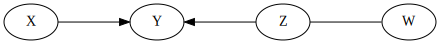

In [3]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

Here is a function that performs the PC algorithm. Add the missing code for phase 2, and implement phases 3 and 4.

In [4]:
def PC_algorithm(n, independence_tester):
    # PHASE I: Initialization
    # The matrix G represents a graph as follows:
    # - For all x, G[x,x] == False
    # - G[x,y] == False and G[y,x] == False: no edge between x and y
    # - G[x,y] == True  and G[y,x] == True:  undirected edge x --- y
    # - G[x,y] == True  and G[y,x] == False: directed edge x --> y
    G = np.logical_not(np.eye(n, dtype=bool))

    # PHASE II: Skeleton search
    # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
    sepset = dict()
    for k in range(n-1):
        for x in range(n):
            for y in range(n):
                if not G[x,y]:
                    continue
                # Try all subsets S of Adj(x) \ {y} with |S|=k,
                # until an independence is found.
                # Hint: use itertools.combinations
                
                # Your code here
                # G[x,y] is true here , this means that y is adjacent to x
                # for all S subset of adjacent nodes to x not including y, with size of S: |S|=k
                l = [i for i in range(n) if (i != y and i != x)] # range n excluding y and x since adj to x
                Set = itertools.combinations(l,k) # all combinations of length k
                
                for S in Set:
                    indep = independence_tester.test_independence(x, y, S)
                    if indep:
                        print("independence found: {0} and {1} given {2}".format(x,y,S))
                        G[x,y] = G[y,x] = False
                        S_mask = np.zeros(n, dtype=bool)
                        np.put(S_mask, S, True)
                        sepset[frozenset([x,y])] = S_mask
                        break
        # Do we need to continue with smaller k? ....
        max_S_size = np.sum(G, axis=0) - 1
        if np.all(max_S_size < k + 1):
            break

    # PHASE III: Orient v-structures
    # Something to watch out for:
    # If the data are not faithful to any graph, the algorithm may end up trying
    # to orient a single edge in two different ways. You can choose either
    # orientation if this happens.

    # Your code here
    # for two not adjacent nodes connected to a third node
    # check if this third node is in the sepset of the two
    # not connected nodes. When the third node is not in
    # the sepset, the two first nodes collide in the third.

    for x in range(n-1):
        for y in range(x,n):
            # if x and y not adjacent
            if G[x,y] == G[y,x] == False and x != y:
                for z in range(n):
                    
                    # when z is adjacent to x and to y
                    if G[x,z] == False and G[z,x] == False:
                        continue
                    if G[y,z] == False and G[z,y] == False:
                        continue
                        
                    # unordered when atleast one edge is undirected
                    if not (G[x,z]==G[z,x]==True or G[y,z]==G[z,y]==True):
                        continue
                        
                    # if z not in sepset({x,y}):
                    if not sepset[frozenset([x,y])][z]:
                        # orient edges
                        G[z,x] = G[z,y] = False
                        
        # Not implemented "Something to watch out for" I do not understand when this exactly would happen...

    # PHASE IV: Orientation rules

    # Your code here
    # no extra v-structures, no cycles
    
    # undirected edges
    for x in range(n):
        for y in range(n):
            # if x and y adjacent and undirected
            if not(G[x,y] == G[y,x] == True and x != y):
                continue
                
            # x and y adjacent and undirected
            for z in range(n):
                # remove cases where z is either x or y
                if z == x or z == y:
                    continue
                if G[x,z] == False and G[z,x] == True:
                    # Rule 1
                    if G[y,z] == False and G[z,y] == False:
                        G[y,x] = False
                        break
                    # Rule 2
                    if G[y,z] == True and G[z,y] == False:
                        G[x,y] = False
                        break
                # Rule 3    
                for q in range(n):
                    if q == z or q == x or q == y:
                        continue
                    if G[x,z] == G[z,x] == True and G[x,q] == G[q,x] == True:
                        if G[z,y] == True and G[y,z] == False:
                            if G[q,y] == True and G[y,q] == False:
                                G[y,x] = False

    '''
    rule 1: When a node has an incoming edge and an undirected edge
                    then the undirected edge becomes a directed outgoing edge.
    rule 2: When two nodes are connected by an undirected edge and 
                have a directed chain connecting them via a third node
                    then the undirected edge becomes a directed edge with the same direction as the chain.
    rule 3: When two nodes are connected by an undirected edge and
                one node has two incoming edges that 'relate' to the 'other' node
                    then the undirected edge becomes a directed edge directed at the node with incoming edges.
    '''
    

    return G

## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an /oracle/ instead of conditional independence test results from a data set. The oracle knows what the true graph is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that graph. In this situation, PC should be able to recover the Markov equivalence class of the true graph.

In [5]:
def is_d_connected_dfs(mB, pos, w, S, vis):
    # Made modifications to deal with CPDAGs as input
    #print("At ", pos)
    (v, dir) = pos
    if v == w:
        return True
    if (dir == 0 and not S[v]) or (dir == 1 and S[v]):
        # traverse backward (dir=0) along an arrow
        next_vs_mask = np.logical_and(mB[v,:], np.logical_not(vis[:,0]))
        if dir == 1:
            # we can't continue on an undirected path in case dir == 1 and S[v])
            next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[:,v]))
        tmp = np.logical_or(vis[:,0], next_vs_mask)
        vis[:,0] = tmp
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 0), w, S, vis):
                return True
    if not S[v]:
        # traverse forward (dir=1) along an arrow
        next_vs_mask = np.logical_and(mB[:,v], np.logical_not(vis[:,1]))
        next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[v,:]))
        vis[:,1] = np.logical_or(vis[:,1], next_vs_mask)
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 1), w, S, vis):
                return True
    return False

def is_d_separated(G, v, w, S):
    if S[v] or S[w]:
        return True
    mB = G.T
    d = mB.shape[0]
    # vis[v,0]: reachable by path ending in tail
    # vis[v,1]: reachable by path ending in head
    vis = np.zeros((d,2), dtype=bool)
    pos = (v,0)
    vis[pos] = True
    is_d_connected_dfs(mB, pos, w, S, vis)
    if vis[w,0] or vis[w,1]:
        return False
    return True

class IndependenceOracle:
    def __init__(self, true_G):
        self.G = true_G
        self.n = true_G.shape[0]
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        #S_mask[S] = True
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true graph for the graph G1 we saw before, and for several other graphs. (You can add more tests to help chase down any bugs.)

independence found: 0 and 2 given ()
independence found: 0 and 3 given ()
independence found: 1 and 3 given (2,)
CORRECT


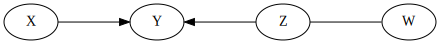

In [6]:
oracle = IndependenceOracle(G1)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G1) else "INCORRECT")
graph_to_graphviz(G, node_names)

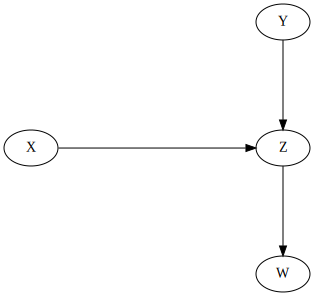

In [7]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

independence found: 0 and 1 given ()
independence found: 0 and 3 given (2,)
independence found: 1 and 3 given (2,)
CORRECT


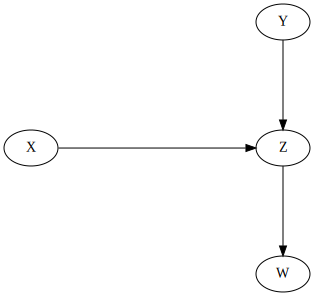

In [8]:
oracle = IndependenceOracle(G2)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G2) else "INCORRECT")
graph_to_graphviz(G, node_names)

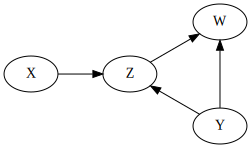

In [9]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)

independence found: 0 and 1 given ()
independence found: 0 and 3 given (1, 2)
CORRECT


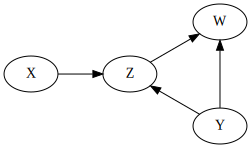

In [10]:
oracle = IndependenceOracle(G3)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G3) else "INCORRECT")
graph_to_graphviz(G, node_names)

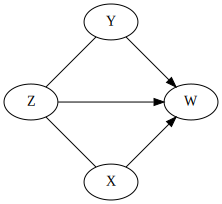

In [11]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

independence found: 0 and 1 given (2,)
CORRECT


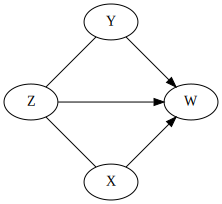

In [12]:
oracle = IndependenceOracle(G4)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G4) else "INCORRECT")
graph_to_graphviz(G, node_names)

## Running PC on data
In this second part of the assignment, you will apply the PC algorithm to the biological dataset of Sachs et al. (2005). In this dataset, the columns represent 11 different proteins, which were measured in thousands of human immune system cells. Each row is a single cell. The cells were prepared in different ways, by adding different chemicals some time before the measurements were made. A twelfth column, labeled 'experiment', indicates in which way that cell was prepared. We can think of experiment=1 as denoting the observational data, and other values of experiment (2 through 14) as various interventional datasets.

In [13]:
import pandas as pd

all_data = pd.read_csv("sachs2005_combined.csv", sep='\t')
# Transform all columns except 'experiment' by taking a logarithm
all_data.loc[:, all_data.columns != 'experiment'] = np.log(all_data.loc[:, all_data.columns != 'experiment'])

We will apply the PC algorithm to just the observational data.

Make a new dataframe containing only the data where experiment equals 1. Remove the `experiment` column from this dataframe. Check the shape of your dataframe: it should be `(853, 11)`.

In [14]:
# Your code here
data_exp1 = all_data[all_data.experiment==1]
data_exp1 = data_exp1.drop(columns='experiment')
data_exp1

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk
0,3.273364,2.580217,2.177022,2.906901,4.074142,1.888584,2.833213,6.025866,2.833213,3.804438,3.688879
1,3.580737,2.803360,2.509599,2.821379,2.095561,2.923162,3.481240,5.863631,1.214913,2.803360,4.119037
2,4.084294,3.786460,2.681022,2.322388,2.564949,2.701361,3.481240,5.998937,2.433613,3.462606,2.970414
3,4.290459,4.416428,3.139833,2.602690,0.254642,1.763017,2.468100,6.269096,2.617396,3.353407,3.139833
4,3.517498,2.985682,1.646734,2.275214,3.210844,3.049273,3.830813,5.720312,1.539015,3.246491,4.398146
...,...,...,...,...,...,...,...,...,...,...,...
848,3.742420,3.317816,3.068053,4.218036,2.509599,2.113843,2.760010,6.331502,3.086487,3.391147,2.113843
849,4.128746,3.077312,2.257588,1.870263,3.535145,2.727853,3.139833,5.765191,2.476538,3.569533,3.929863
850,4.634729,3.471966,2.322388,2.580217,3.929863,1.663926,1.726332,5.476464,2.674149,3.131137,1.654411
851,4.352855,3.165475,3.210844,4.100989,3.795489,3.068053,3.218876,5.666427,3.471966,4.424847,3.299534


To run the PC algorithm on data, we need to perform (conditional) independence tests. The package [tigramite](https://github.com/jakobrunge/tigramite) implements several such tests. The simplest of these tests is ParCorr(). It assumes the data come from a linear model, which they actually don't. We will use it anyway, because the alternatives (such as CMIknn() (Runge, 2018)) are more effort to install and orders of magnitude slower.

As a statistical test, a conditional independence test works by computing a p-value. If a conditional independence exists, this p-value will be approximately uniformly distributed on the interval between 0 and 1. If the variables being tested are conditionally dependent, the p-value will be close to 0. PC wants to know a binary answer, so we will pick some threshold alpha and declare an independence if the p-value is larger than alpha.

In statistical testing, alpha is often taken to be 0.05 or smaller. For PC, it may be more appropriate to pick a (much) larger alpha instead. This is because as soon as PC finds a (conditional) independence between two variables, it will delete the edge between them and do no more tests between those two variables. If this happens while it shouldn't have, PC can't put the edge back. But in the reverse situation, if PC leaves an edge in place while it should have deleted it, there is still a possibility that the edge will be deleted later, when another test between those two variables reports a more convincing independence.

In [15]:
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp
# Importing these may give some warnings (e.g. 'Could not import r-package RCIT'),
# but most of these warnings can be ignored because we are not using the mentioned packages.

class IndependenceTester:
    def __init__(self, data, cond_ind_test, alpha):
        # data: a pandas dataframe
        # cond_ind_test: an independence test from tigramite, e.g. ParCorr()
        # alpha: the significance level to which the p-values are compared
        
        # tigramite uses its own kind of dataframe, so convert the data to that format
        df_tigramite = pp.DataFrame(data.to_numpy(), var_names=data.columns)
        self.cond_ind_test = cond_ind_test
        self.cond_ind_test.set_dataframe(df_tigramite)
        self.n = data.shape[1]
        self.alpha = alpha
    def test_independence(self, x, y, S):
        val, pval = self.cond_ind_test.run_test(X=[(x, 0)],
                                                Y=[(y, 0)],
                                                Z=[(z, 0) for z in S])
        print("test: {0} and {1} given {2} -> pval={3}".format(x,y,S,pval))
        return pval > self.alpha

Could not import rpy package
Could not import r-package RCIT


Using an IndependenceTester object (which works similarly to the IndependenceOracle we used earlier), run the PC algorithm on the observational data. Display the graph that comes out. You may experiment with different values of alpha; the graph you get should have just one or two connected components.

test: 0 and 1 given () -> pval=2.763329247780076e-116
test: 0 and 2 given () -> pval=0.7345031780389384
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.7147143030936396
independence found: 0 and 3 given ()
test: 0 and 4 given () -> pval=0.4639779567396791
independence found: 0 and 4 given ()
test: 0 and 5 given () -> pval=0.49429391475369566
independence found: 0 and 5 given ()
test: 0 and 6 given () -> pval=0.24104570427628094
independence found: 0 and 6 given ()
test: 0 and 7 given () -> pval=0.8820017123329296
independence found: 0 and 7 given ()
test: 0 and 8 given () -> pval=0.3264140832119329
independence found: 0 and 8 given ()
test: 0 and 9 given () -> pval=0.11406363143778013
test: 0 and 10 given () -> pval=0.773348151789071
independence found: 0 and 10 given ()
test: 1 and 0 given () -> pval=2.763329247780076e-116
test: 1 and 2 given () -> pval=0.9899798095695264
independence found: 1 and 2 given ()
test: 1 and 3 given () -> pval=0.6357149945587127
indep

test: 9 and 10 given (4,) -> pval=0.02864859473163029
test: 9 and 10 given (5,) -> pval=0.028574025085048506
test: 9 and 10 given (6,) -> pval=0.028954730690347645
test: 9 and 10 given (7,) -> pval=0.029986900774719945
test: 9 and 10 given (8,) -> pval=0.1163182571160223
test: 10 and 1 given (0,) -> pval=0.037252153405682734
test: 10 and 1 given (2,) -> pval=0.18198854581043358
test: 10 and 1 given (3,) -> pval=0.1810718681575145
test: 10 and 1 given (4,) -> pval=0.16777298348477615
test: 10 and 1 given (5,) -> pval=0.1846881628079955
test: 10 and 1 given (6,) -> pval=0.18259682126481455
test: 10 and 1 given (7,) -> pval=0.18171416892746212
test: 10 and 1 given (8,) -> pval=0.10620239707157475
test: 10 and 1 given (9,) -> pval=0.15304499242251715
test: 10 and 8 given (0,) -> pval=2.643188890427205e-09
test: 10 and 8 given (1,) -> pval=1.658422451306406e-09
test: 10 and 8 given (2,) -> pval=2.7879888637156725e-09
test: 10 and 8 given (3,) -> pval=2.605130097376399e-09
test: 10 and 8 giv

test: 3 and 4 given (5, 10) -> pval=4.618938780233255e-26
test: 3 and 4 given (6, 7) -> pval=6.25724687675847e-26
test: 3 and 4 given (6, 8) -> pval=4.7215661178934996e-26
test: 3 and 4 given (6, 9) -> pval=5.29144774598065e-26
test: 3 and 4 given (6, 10) -> pval=5.458081275341016e-26
test: 3 and 4 given (7, 8) -> pval=6.232892560233888e-26
test: 3 and 4 given (7, 9) -> pval=6.96689201652728e-26
test: 3 and 4 given (7, 10) -> pval=7.229440819591397e-26
test: 3 and 4 given (8, 9) -> pval=5.397635952637085e-26
test: 3 and 4 given (8, 10) -> pval=6.010702105973447e-26
test: 3 and 4 given (9, 10) -> pval=6.978268422523199e-26
test: 4 and 1 given (0, 2) -> pval=0.11399695640485098
test: 4 and 1 given (0, 3) -> pval=0.1988699027065482
test: 4 and 1 given (0, 5) -> pval=0.1135766987706972
test: 4 and 1 given (0, 6) -> pval=0.1180085885155085
test: 4 and 1 given (0, 7) -> pval=0.12147740636558009
test: 4 and 1 given (0, 8) -> pval=0.11940067114509807
test: 4 and 1 given (0, 9) -> pval=0.121541

test: 7 and 6 given (3, 10) -> pval=1.1672908907950378e-34
test: 7 and 6 given (4, 5) -> pval=1.4124659197721391e-10
test: 7 and 6 given (4, 8) -> pval=1.0647506816339333e-34
test: 7 and 6 given (4, 9) -> pval=8.102512553634598e-35
test: 7 and 6 given (4, 10) -> pval=8.414940995746944e-35
test: 7 and 6 given (5, 8) -> pval=1.5309001746367952e-10
test: 7 and 6 given (5, 9) -> pval=1.9771609162560015e-10
test: 7 and 6 given (5, 10) -> pval=1.5191350195409692e-10
test: 7 and 6 given (8, 9) -> pval=1.2489359371435342e-34
test: 7 and 6 given (8, 10) -> pval=1.3159399464955862e-34
test: 7 and 6 given (9, 10) -> pval=1.002777343791157e-34
test: 8 and 9 given (0, 1) -> pval=4.761870464931692e-78
test: 8 and 9 given (0, 2) -> pval=5.0464574687604125e-78
test: 8 and 9 given (0, 3) -> pval=3.4372827549176438e-78
test: 8 and 9 given (0, 4) -> pval=4.959202777032943e-78
test: 8 and 9 given (0, 5) -> pval=2.849841273124596e-78
test: 8 and 9 given (0, 6) -> pval=4.591473157935366e-78
test: 8 and 9 gi

test: 10 and 9 given (7, 8) -> pval=0.116306609083664


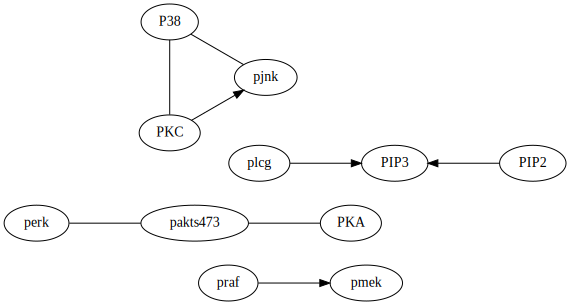

In [16]:
# Your code here
tester = IndependenceTester(data_exp1, ParCorr(), alpha=0.2)

G = PC_algorithm(11, tester)
graph_to_graphviz(G, list(data_exp1.columns))


Now let's look at what else is in the dataset: the interventional data corresponding to different experiments.

The interventions in these experiment are not perfect interventions: they change the structural equation of a variable, but not by setting it to a constant. The new structural equation in the intervened model may still include all variables that were there in the original model. So in the graph of the intervened model, all arrows will still be there.

Further, some of the interventions change not one, but multiple structural equations.

For some of the interventions in the data, here is what they do according to many (but not all) experts:
* experiment 5 adds the substance psitectorigenin, which modifies the amount of PIP2;
* experiment 6 adds the substance U0126, which increases the *activity* of pmek. This means that the amount of pmek is not changed by the intervention, but for all *children* of pmek in the causal model, the structural equation changes to reflect that pmek now has a stronger effect on them. pmek is believed to have only one child in the true causal model, namely perk.

(Source: Mooij et al., 2019, specifically Tables 2 & 3 and Figure 35(a))

Create two new dataframes, one containing all data from experiments 1 and 5, and one with the data from experiments 1 and 6. These dataframes should still have an 'experiment' column, so that you can tell for each row whether it came from the observational or the interventional dataset.

In [17]:
# Your code here
data_exp1 = all_data[all_data.experiment==1]
data_exp5 = all_data[all_data.experiment==5]
data_exp6 = all_data[all_data.experiment==6]

data_exp1_5 = pd.concat([data_exp1, data_exp5], sort=False)
data_exp1_6 = pd.concat([data_exp1, data_exp6], sort=False)

In [18]:
data_exp1_5

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk,experiment
0,3.273364,2.580217,2.177022,2.906901,4.074142,1.888584,2.833213,6.025866,2.833213,3.804438,3.688879,1
1,3.580737,2.803360,2.509599,2.821379,2.095561,2.923162,3.481240,5.863631,1.214913,2.803360,4.119037,1
2,4.084294,3.786460,2.681022,2.322388,2.564949,2.701361,3.481240,5.998937,2.433613,3.462606,2.970414,1
3,4.290459,4.416428,3.139833,2.602690,0.254642,1.763017,2.468100,6.269096,2.617396,3.353407,3.139833,1
4,3.517498,2.985682,1.646734,2.275214,3.210844,3.049273,3.830813,5.720312,1.539015,3.246491,4.398146,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4194,4.110874,3.713572,1.376244,1.366092,2.985682,3.317816,3.795489,5.872118,3.363842,4.237001,3.552487,5
4195,4.254193,3.202746,0.000000,1.510722,3.758872,4.370713,5.043425,7.708411,1.376244,2.484907,3.508556,5
4196,4.136765,3.139833,1.205971,1.196948,2.660260,2.674149,3.317816,5.872118,2.879198,3.407842,1.223775,5
4197,4.727388,4.290459,0.000000,0.270027,2.442347,2.167910,3.437208,6.188264,3.688879,4.380776,3.777348,5


In [19]:
data_exp1_6

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk,experiment
0,3.273364,2.580217,2.177022,2.906901,4.074142,1.888584,2.833213,6.025866,2.833213,3.804438,3.688879,1
1,3.580737,2.803360,2.509599,2.821379,2.095561,2.923162,3.481240,5.863631,1.214913,2.803360,4.119037,1
2,4.084294,3.786460,2.681022,2.322388,2.564949,2.701361,3.481240,5.998937,2.433613,3.462606,2.970414,1
3,4.290459,4.416428,3.139833,2.602690,0.254642,1.763017,2.468100,6.269096,2.617396,3.353407,3.139833,1
4,3.517498,2.985682,1.646734,2.275214,3.210844,3.049273,3.830813,5.720312,1.539015,3.246491,4.398146,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4993,4.056989,4.515245,2.844909,2.753661,1.879465,1.591274,3.561046,4.804021,0.277632,3.005683,1.501853,6
4994,5.846439,6.386879,2.753661,2.493205,2.975530,0.000000,4.074142,5.062595,0.576613,3.471966,1.465568,6
4995,4.779123,5.056246,2.602690,4.795791,3.696351,0.989541,3.885679,5.147494,2.501436,3.374169,3.650658,6
4996,5.416100,5.872118,2.797281,2.995732,2.221375,3.020425,5.332719,8.014005,3.039749,4.434382,3.841601,6


**Question**: In the dataframe for experiments 1 and 5, look at PIP2 and the variables that were adjacent to it in the output of PC. Based on looking at some plots, does the data give evidence for or against the hypothesis that psitectorigenin modifies PIP2? And what does the data for the two experiments seem to say about the directions of the arrows between PIP2 and its neighbours?

Insert one or more markdown and code boxes below here to give your answer and the plots you base your answer on. (Put your answer in markdown boxes, not as comments in your code!)

**Answer**: Based on comparing the structural graph of experiment 1 to the graph of experiments 1 and 5, we can see that PIP2 is much more connected. This means that PIP2 is influenced by more other proteins than in the graph of experiment 1. Additionally, the directional connection between PIP2 and PIP3 has changed direction, indicating that something in the way PIP2 functions has changed. The structural equation has evidently changed. It seems likely, then, that PIP2 has been modified by adding psitectorigenin. 

test: 0 and 1 given () -> pval=2.763329247780076e-116
test: 0 and 2 given () -> pval=0.7345031780389384
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.7147143030936396
independence found: 0 and 3 given ()
test: 0 and 4 given () -> pval=0.4639779567396791
independence found: 0 and 4 given ()
test: 0 and 5 given () -> pval=0.49429391475369566
independence found: 0 and 5 given ()
test: 0 and 6 given () -> pval=0.24104570427628094
independence found: 0 and 6 given ()
test: 0 and 7 given () -> pval=0.8820017123329296
independence found: 0 and 7 given ()
test: 0 and 8 given () -> pval=0.3264140832119329
independence found: 0 and 8 given ()
test: 0 and 9 given () -> pval=0.11406363143778013
test: 0 and 10 given () -> pval=0.773348151789071
independence found: 0 and 10 given ()
test: 1 and 0 given () -> pval=2.763329247780076e-116
test: 1 and 2 given () -> pval=0.9899798095695264
independence found: 1 and 2 given ()
test: 1 and 3 given () -> pval=0.6357149945587127
indep

test: 0 and 1 given (2, 10) -> pval=1.397979608306598e-116
test: 0 and 1 given (3, 4) -> pval=5.290564537903058e-116
test: 0 and 1 given (3, 5) -> pval=1.3718285241105735e-116
test: 0 and 1 given (3, 6) -> pval=3.454102845159118e-116
test: 0 and 1 given (3, 7) -> pval=3.57302655826322e-116
test: 0 and 1 given (3, 8) -> pval=5.628305324578839e-116
test: 0 and 1 given (3, 9) -> pval=7.307213887032396e-116
test: 0 and 1 given (3, 10) -> pval=9.662718348341923e-117
test: 0 and 1 given (4, 5) -> pval=2.1178488674284914e-116
test: 0 and 1 given (4, 6) -> pval=5.430137019240432e-116
test: 0 and 1 given (4, 7) -> pval=5.950798670295215e-116
test: 0 and 1 given (4, 8) -> pval=9.412828937885776e-116
test: 0 and 1 given (4, 9) -> pval=1.2163721382887523e-115
test: 0 and 1 given (4, 10) -> pval=1.5797947978888474e-116
test: 0 and 1 given (5, 6) -> pval=3.3372701738330343e-116
test: 0 and 1 given (5, 7) -> pval=1.637537286495684e-116
test: 0 and 1 given (5, 8) -> pval=2.990699665737279e-116
test: 0

test: 4 and 2 given (6, 8) -> pval=0.00763753065940746
test: 4 and 2 given (6, 9) -> pval=0.007757366247279278
test: 4 and 2 given (6, 10) -> pval=0.008560161084605871
test: 4 and 2 given (7, 8) -> pval=0.007967526334149565
test: 4 and 2 given (7, 9) -> pval=0.008069102410875148
test: 4 and 2 given (7, 10) -> pval=0.008892885572929284
test: 4 and 2 given (8, 9) -> pval=0.008134277220367175
test: 4 and 2 given (8, 10) -> pval=0.00898764924457173
test: 4 and 2 given (9, 10) -> pval=0.009066464108862868
test: 4 and 3 given (0, 1) -> pval=8.225772874176714e-26
test: 4 and 3 given (0, 2) -> pval=9.434178256401724e-26
test: 4 and 3 given (0, 5) -> pval=3.840505552321666e-26
test: 4 and 3 given (0, 6) -> pval=4.5631946307737215e-26
test: 4 and 3 given (0, 7) -> pval=5.944956057787305e-26
test: 4 and 3 given (0, 8) -> pval=5.0739800885444075e-26
test: 4 and 3 given (0, 9) -> pval=5.733347737990406e-26
test: 4 and 3 given (0, 10) -> pval=5.882100781185691e-26
test: 4 and 3 given (1, 2) -> pval=

test: 9 and 8 given (2, 4) -> pval=3.1650483961369846e-78
test: 9 and 8 given (2, 5) -> pval=1.842463874242193e-78
test: 9 and 8 given (2, 6) -> pval=3.012471312439051e-78
test: 9 and 8 given (2, 7) -> pval=5.689185176400313e-78
test: 9 and 8 given (2, 10) -> pval=9.740729580814437e-78
test: 9 and 8 given (3, 4) -> pval=1.9076395933883647e-78
test: 9 and 8 given (3, 5) -> pval=1.2049189955088993e-78
test: 9 and 8 given (3, 6) -> pval=2.0174818849938734e-78
test: 9 and 8 given (3, 7) -> pval=3.823999322541158e-78
test: 9 and 8 given (3, 10) -> pval=6.84070414303289e-78
test: 9 and 8 given (4, 5) -> pval=1.7922222054200736e-78
test: 9 and 8 given (4, 6) -> pval=2.9194704569819717e-78
test: 9 and 8 given (4, 7) -> pval=5.544317399414906e-78
test: 9 and 8 given (4, 10) -> pval=9.701807555576991e-78
test: 9 and 8 given (5, 6) -> pval=1.508693031223176e-78
test: 9 and 8 given (5, 7) -> pval=3.6234831673619676e-78
test: 9 and 8 given (5, 10) -> pval=5.782908533732419e-78
test: 9 and 8 given (

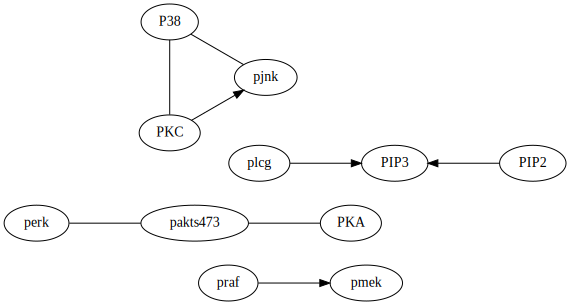

In [26]:
# For completeness: the graph over the data of experiment 1 again

data_exp1_drop = data_exp1.drop(columns='experiment')
tester = IndependenceTester(data_exp1_drop, ParCorr(), alpha=0.2)

G = PC_algorithm(11, tester)
graph_to_graphviz(G, list(data_exp1_drop.columns))

test: 0 and 1 given () -> pval=2.5660310864901142e-76
test: 0 and 2 given () -> pval=0.2929179013370879
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.35108397360442845
independence found: 0 and 3 given ()
test: 0 and 4 given () -> pval=0.6990282910365165
independence found: 0 and 4 given ()
test: 0 and 5 given () -> pval=0.11634169900900078
test: 0 and 6 given () -> pval=0.021929307138229662
test: 0 and 7 given () -> pval=0.08625159005373143
test: 0 and 8 given () -> pval=0.88734285648177
independence found: 0 and 8 given ()
test: 0 and 9 given () -> pval=0.35331270087311606
independence found: 0 and 9 given ()
test: 0 and 10 given () -> pval=0.7865233062294104
independence found: 0 and 10 given ()
test: 1 and 0 given () -> pval=2.5660310864901142e-76
test: 1 and 2 given () -> pval=0.15532799932138003
test: 1 and 3 given () -> pval=0.2664159403236012
independence found: 1 and 3 given ()
test: 1 and 4 given () -> pval=0.2085655048949159
independence found: 1 and 

test: 8 and 9 given (3,) -> pval=2.129493242778107e-107
test: 8 and 9 given (4,) -> pval=3.1684551502761024e-107
test: 8 and 9 given (5,) -> pval=1.995203837215264e-107
test: 8 and 9 given (6,) -> pval=1.9749335622539405e-107
test: 8 and 9 given (7,) -> pval=1.4567133624046373e-107
test: 8 and 9 given (10,) -> pval=8.984754302379991e-117
test: 8 and 10 given (0,) -> pval=0.005627787320009397
test: 8 and 10 given (1,) -> pval=0.005937397504105572
test: 8 and 10 given (2,) -> pval=0.005637898156168613
test: 8 and 10 given (3,) -> pval=0.005732496343766033
test: 8 and 10 given (4,) -> pval=0.005872441679358642
test: 8 and 10 given (5,) -> pval=0.005664207170280162
test: 8 and 10 given (6,) -> pval=0.005787328482154387
test: 8 and 10 given (7,) -> pval=0.0056641430767078345
test: 8 and 10 given (9,) -> pval=1.1611599001803462e-12
test: 9 and 1 given (0,) -> pval=0.027582801988291168
test: 9 and 1 given (2,) -> pval=0.020772894558367512
test: 9 and 1 given (3,) -> pval=0.021078182388215502


test: 2 and 7 given (0, 9) -> pval=0.041299728674032886
test: 2 and 7 given (0, 10) -> pval=0.04008337461311783
test: 2 and 7 given (1, 3) -> pval=0.046730036893677766
test: 2 and 7 given (1, 4) -> pval=0.04576862950380254
test: 2 and 7 given (1, 5) -> pval=0.0707562637163191
test: 2 and 7 given (1, 6) -> pval=0.05138366468413015
test: 2 and 7 given (1, 8) -> pval=0.0543515772654212
test: 2 and 7 given (1, 9) -> pval=0.055190560967365264
test: 2 and 7 given (1, 10) -> pval=0.05421826391603925
test: 2 and 7 given (3, 4) -> pval=0.03599582648093367
test: 2 and 7 given (3, 5) -> pval=0.055758108449846404
test: 2 and 7 given (3, 6) -> pval=0.040749523744665624
test: 2 and 7 given (3, 8) -> pval=0.040365964223631194
test: 2 and 7 given (3, 9) -> pval=0.04158104199529049
test: 2 and 7 given (3, 10) -> pval=0.040304091970952145
test: 2 and 7 given (4, 5) -> pval=0.048374110358662105
test: 2 and 7 given (4, 6) -> pval=0.03898751129478636
test: 2 and 7 given (4, 8) -> pval=0.040139455129422734


test: 6 and 5 given (4, 8) -> pval=3.894939960264693e-229
test: 6 and 5 given (4, 9) -> pval=3.915388665736469e-229
test: 6 and 5 given (4, 10) -> pval=8.309603737999205e-230
test: 6 and 5 given (7, 8) -> pval=1.853904342883984e-206
test: 6 and 5 given (7, 9) -> pval=1.7684709779462983e-206
test: 6 and 5 given (7, 10) -> pval=3.536549658239637e-207
test: 6 and 5 given (8, 9) -> pval=1.291318045918057e-228
test: 6 and 5 given (8, 10) -> pval=2.52597132156768e-229
test: 6 and 5 given (9, 10) -> pval=2.7121833839325436e-229
test: 6 and 7 given (0, 1) -> pval=3.1086483111205474e-47
test: 6 and 7 given (0, 2) -> pval=3.539620127088403e-47
test: 6 and 7 given (0, 3) -> pval=3.324171563708476e-47
test: 6 and 7 given (0, 4) -> pval=3.0328822847564715e-47
test: 6 and 7 given (0, 5) -> pval=3.1651102283453283e-25
test: 6 and 7 given (0, 8) -> pval=3.2665406138437497e-47
test: 6 and 7 given (0, 9) -> pval=3.1402705010722217e-47
test: 6 and 7 given (0, 10) -> pval=3.4275796840946515e-47
test: 6 an

test: 9 and 8 given (2, 6) -> pval=2.8447085479005884e-107
test: 9 and 8 given (2, 7) -> pval=2.0683470819551086e-107
test: 9 and 8 given (2, 10) -> pval=1.3323076901729357e-116
test: 9 and 8 given (3, 4) -> pval=3.868754541580132e-107
test: 9 and 8 given (3, 5) -> pval=2.957213345585728e-107
test: 9 and 8 given (3, 6) -> pval=2.932502591444495e-107
test: 9 and 8 given (3, 7) -> pval=2.1062335460211685e-107
test: 9 and 8 given (3, 10) -> pval=1.3895364480165395e-116
test: 9 and 8 given (4, 5) -> pval=4.4642285880169844e-107
test: 9 and 8 given (4, 6) -> pval=4.370056085318281e-107
test: 9 and 8 given (4, 7) -> pval=3.209063458456091e-107
test: 9 and 8 given (4, 10) -> pval=2.0141891721270852e-116
test: 9 and 8 given (5, 6) -> pval=2.6810033721108032e-107
test: 9 and 8 given (5, 7) -> pval=1.791450733602851e-107
test: 9 and 8 given (5, 10) -> pval=1.2889555899918486e-116
test: 9 and 8 given (6, 7) -> pval=1.727451201359657e-107
test: 9 and 8 given (6, 10) -> pval=1.2403214376133348e-116

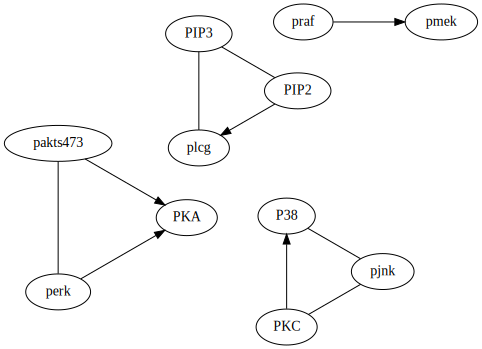

In [29]:
# Only the data from experiment 5, as an additional check

data_exp5_drop = data_exp5.drop(columns='experiment')
tester = IndependenceTester(data_exp5_drop, ParCorr(), alpha=0.2)

G = PC_algorithm(11, tester)
graph_to_graphviz(G, list(data_exp5_drop.columns))

test: 0 and 1 given () -> pval=2.0376953059899394e-183
test: 0 and 2 given () -> pval=0.7288925242787185
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.7124053354557727
independence found: 0 and 3 given ()
test: 0 and 4 given () -> pval=0.791738305990526
independence found: 0 and 4 given ()
test: 0 and 5 given () -> pval=0.10986481189123287
test: 0 and 6 given () -> pval=0.01472987772599981
test: 0 and 7 given () -> pval=0.15894275506361807
test: 0 and 8 given () -> pval=0.5617195629350336
independence found: 0 and 8 given ()
test: 0 and 9 given () -> pval=0.7455552457561689
independence found: 0 and 9 given ()
test: 0 and 10 given () -> pval=0.6894501241406117
independence found: 0 and 10 given ()
test: 1 and 0 given () -> pval=2.0376953059899394e-183
test: 1 and 2 given () -> pval=0.2804036871272833
independence found: 1 and 2 given ()
test: 1 and 3 given () -> pval=0.008173779888968266
test: 1 and 4 given () -> pval=0.4030837010156133
independence found: 1 and

test: 3 and 9 given (7,) -> pval=1.892178513947093e-09
test: 3 and 9 given (8,) -> pval=0.00034963402812607925
test: 3 and 9 given (10,) -> pval=1.4395934079399777e-09
test: 3 and 10 given (0,) -> pval=0.18548115853165084
test: 3 and 10 given (1,) -> pval=0.21936850451128864
independence found: 3 and 10 given (1,)
test: 4 and 2 given (0,) -> pval=1.996103907159019e-36
test: 4 and 2 given (1,) -> pval=1.3977975982252813e-36
test: 4 and 2 given (3,) -> pval=0.0027385884408152403
test: 4 and 2 given (5,) -> pval=6.300937031030442e-34
test: 4 and 2 given (6,) -> pval=1.5159169863834416e-32
test: 4 and 2 given (7,) -> pval=1.9220168427207177e-36
test: 4 and 2 given (8,) -> pval=1.2636016637235148e-35
test: 4 and 2 given (9,) -> pval=6.474743806795894e-35
test: 4 and 2 given (10,) -> pval=3.3671028827053136e-36
test: 4 and 3 given (0,) -> pval=7.494614527918964e-83
test: 4 and 3 given (1,) -> pval=8.814818246720851e-84
test: 4 and 3 given (2,) -> pval=3.578837810052694e-50
test: 4 and 3 give

test: 0 and 1 given (9, 10) -> pval=3.0184595298039296e-184
test: 0 and 6 given (1, 2) -> pval=0.0032723131419249187
test: 0 and 6 given (1, 3) -> pval=0.008252196206259443
test: 0 and 6 given (1, 4) -> pval=0.0024071425688431385
test: 0 and 6 given (1, 5) -> pval=0.22836480364935235
independence found: 0 and 6 given (1, 5)
test: 1 and 0 given (2, 3) -> pval=7.693558001491535e-184
test: 1 and 0 given (2, 4) -> pval=3.1255813753656607e-183
test: 1 and 0 given (2, 5) -> pval=3.2141339974789416e-184
test: 1 and 0 given (2, 6) -> pval=1.118782361082393e-183
test: 1 and 0 given (2, 7) -> pval=4.889890568500318e-183
test: 1 and 0 given (2, 8) -> pval=2.9199798093123912e-183
test: 1 and 0 given (2, 9) -> pval=1.2968054865151182e-183
test: 1 and 0 given (2, 10) -> pval=8.534901874330346e-184
test: 1 and 0 given (3, 4) -> pval=4.829432148269709e-184
test: 1 and 0 given (3, 5) -> pval=1.6167637377371402e-184
test: 1 and 0 given (3, 6) -> pval=8.248533630364456e-184
test: 1 and 0 given (3, 7) -> 

test: 2 and 9 given (0, 10) -> pval=7.157059757805667e-06
test: 2 and 9 given (1, 3) -> pval=0.16624736605952395
test: 2 and 9 given (1, 4) -> pval=0.0003673849401055217
test: 2 and 9 given (1, 5) -> pval=1.6061452485897784e-05
test: 2 and 9 given (1, 6) -> pval=4.1153838864365135e-05
test: 2 and 9 given (1, 7) -> pval=1.1258529127872076e-05
test: 2 and 9 given (1, 8) -> pval=0.0031359877123959337
test: 2 and 9 given (1, 10) -> pval=8.33132343554982e-06
test: 2 and 9 given (3, 4) -> pval=0.18695150262794172
test: 2 and 9 given (3, 5) -> pval=0.17035254264668057
test: 2 and 9 given (3, 6) -> pval=0.18261426246341203
test: 2 and 9 given (3, 7) -> pval=0.17515685245280613
test: 2 and 9 given (3, 8) -> pval=0.21459417694613256
independence found: 2 and 9 given (3, 8)
test: 3 and 1 given (0, 2) -> pval=0.0028214833545803725
test: 3 and 1 given (0, 4) -> pval=9.411775673839701e-05
test: 3 and 1 given (0, 5) -> pval=0.0062949307598818656
test: 3 and 1 given (0, 6) -> pval=0.005637392591091836

test: 3 and 9 given (0, 8) -> pval=0.00035161751937868267
test: 3 and 9 given (0, 10) -> pval=1.4235457495112432e-09
test: 3 and 9 given (1, 2) -> pval=2.4565028638900438e-05
test: 3 and 9 given (1, 4) -> pval=7.513492007022108e-07
test: 3 and 9 given (1, 5) -> pval=4.839261531566645e-09
test: 3 and 9 given (1, 6) -> pval=1.9848073166813216e-08
test: 3 and 9 given (1, 7) -> pval=2.931663507873868e-09
test: 3 and 9 given (1, 8) -> pval=0.0005000078306799635
test: 3 and 9 given (1, 10) -> pval=2.225294030741565e-09
test: 3 and 9 given (2, 4) -> pval=0.00016857246239245383
test: 3 and 9 given (2, 5) -> pval=2.146643349737487e-05
test: 3 and 9 given (2, 6) -> pval=3.694764498326015e-05
test: 3 and 9 given (2, 7) -> pval=1.8604526842052037e-05
test: 3 and 9 given (2, 8) -> pval=0.020611280449352447
test: 3 and 9 given (2, 10) -> pval=1.764299905776259e-05
test: 3 and 9 given (4, 5) -> pval=6.241857915074068e-07
test: 3 and 9 given (4, 6) -> pval=1.6260570389525146e-06
test: 3 and 9 given (4

test: 6 and 3 given (5, 9) -> pval=5.6196710641819506e-14
test: 6 and 3 given (5, 10) -> pval=6.500546814059571e-15
test: 6 and 3 given (7, 8) -> pval=2.14434934490733e-25
test: 6 and 3 given (7, 9) -> pval=5.763316126822609e-25
test: 6 and 3 given (7, 10) -> pval=6.36301409333181e-26
test: 6 and 3 given (8, 9) -> pval=4.032733577750973e-23
test: 6 and 3 given (8, 10) -> pval=1.918007992501063e-23
test: 6 and 3 given (9, 10) -> pval=2.7216932181380755e-23
test: 6 and 5 given (0, 1) -> pval=0.0
test: 6 and 5 given (0, 2) -> pval=0.0
test: 6 and 5 given (0, 3) -> pval=0.0
test: 6 and 5 given (0, 4) -> pval=0.0
test: 6 and 5 given (0, 7) -> pval=0.0
test: 6 and 5 given (0, 8) -> pval=0.0
test: 6 and 5 given (0, 9) -> pval=0.0
test: 6 and 5 given (0, 10) -> pval=0.0
test: 6 and 5 given (1, 2) -> pval=0.0
test: 6 and 5 given (1, 3) -> pval=0.0
test: 6 and 5 given (1, 4) -> pval=0.0
test: 6 and 5 given (1, 7) -> pval=0.0
test: 6 and 5 given (1, 8) -> pval=0.0
test: 6 and 5 given (1, 9) -> pv

test: 8 and 10 given (6, 7) -> pval=1.450468722057848e-10
test: 8 and 10 given (6, 9) -> pval=4.411025844495568e-19
test: 8 and 10 given (7, 9) -> pval=4.702277158777276e-19
test: 9 and 3 given (0, 1) -> pval=3.59477880209324e-09
test: 9 and 3 given (0, 2) -> pval=1.8525734010143126e-05
test: 9 and 3 given (0, 4) -> pval=4.532970963605074e-07
test: 9 and 3 given (0, 5) -> pval=3.1679332358010945e-09
test: 9 and 3 given (0, 6) -> pval=1.2497926586352696e-08
test: 9 and 3 given (0, 7) -> pval=1.869859754772293e-09
test: 9 and 3 given (0, 8) -> pval=0.00035161751937868175
test: 9 and 3 given (0, 10) -> pval=1.4235457495112432e-09
test: 9 and 3 given (1, 2) -> pval=2.4565028638900438e-05
test: 9 and 3 given (1, 4) -> pval=7.513492007022081e-07
test: 9 and 3 given (1, 5) -> pval=4.839261531566645e-09
test: 9 and 3 given (1, 6) -> pval=1.9848073166813216e-08
test: 9 and 3 given (1, 7) -> pval=2.9316635078738674e-09
test: 9 and 3 given (1, 8) -> pval=0.0005000078306799635
test: 9 and 3 given 

test: 0 and 1 given (6, 7, 10) -> pval=2.636150982344391e-184
test: 0 and 1 given (6, 8, 9) -> pval=4.907550570322013e-184
test: 0 and 1 given (6, 8, 10) -> pval=2.5080365910429297e-184
test: 0 and 1 given (6, 9, 10) -> pval=1.0551974404407507e-184
test: 0 and 1 given (7, 8, 9) -> pval=2.4446373474322275e-183
test: 0 and 1 given (7, 8, 10) -> pval=1.500385481970304e-183
test: 0 and 1 given (7, 9, 10) -> pval=5.485756743504948e-184
test: 0 and 1 given (8, 9, 10) -> pval=3.660451975175364e-184
test: 1 and 0 given (2, 3, 4) -> pval=5.598244097844179e-184
test: 1 and 0 given (2, 3, 5) -> pval=1.6576014567077946e-184
test: 1 and 0 given (2, 3, 6) -> pval=8.363262767242601e-184
test: 1 and 0 given (2, 3, 7) -> pval=1.4651551598931183e-183
test: 1 and 0 given (2, 3, 8) -> pval=1.004866794389322e-183
test: 1 and 0 given (2, 3, 9) -> pval=4.965190849445002e-184
test: 1 and 0 given (2, 3, 10) -> pval=2.6651896160596006e-184
test: 1 and 0 given (2, 4, 5) -> pval=3.393416078969688e-184
test: 1 and

test: 1 and 10 given (3, 4, 7) -> pval=0.15033107536497906
test: 1 and 10 given (3, 4, 8) -> pval=0.13540590716412018
test: 1 and 10 given (3, 4, 9) -> pval=0.1446749282521308
test: 1 and 10 given (3, 5, 6) -> pval=0.19459230697967195
test: 1 and 10 given (3, 5, 7) -> pval=0.1653675635990023
test: 1 and 10 given (3, 5, 8) -> pval=0.14841003848301224
test: 1 and 10 given (3, 5, 9) -> pval=0.15907240391740463
test: 1 and 10 given (3, 6, 7) -> pval=0.16711983989806561
test: 1 and 10 given (3, 6, 8) -> pval=0.1527113148665542
test: 1 and 10 given (3, 6, 9) -> pval=0.16264413193685326
test: 1 and 10 given (3, 7, 8) -> pval=0.1485309366694343
test: 1 and 10 given (3, 7, 9) -> pval=0.15764704322944803
test: 1 and 10 given (3, 8, 9) -> pval=0.09332349286334611
test: 1 and 10 given (4, 5, 6) -> pval=0.1520889188949312
test: 1 and 10 given (4, 5, 7) -> pval=0.13565303683418992
test: 1 and 10 given (4, 5, 8) -> pval=0.1348550675973065
test: 1 and 10 given (4, 5, 9) -> pval=0.12843730898820427
tes

test: 2 and 6 given (1, 3, 10) -> pval=0.004537416469440263
test: 2 and 6 given (1, 4, 5) -> pval=1.3213673533266065e-07
test: 2 and 6 given (1, 4, 7) -> pval=6.648424289395612e-09
test: 2 and 6 given (1, 4, 8) -> pval=5.49819489579956e-11
test: 2 and 6 given (1, 4, 9) -> pval=6.654103712798645e-11
test: 2 and 6 given (1, 4, 10) -> pval=2.6222217230719667e-11
test: 2 and 6 given (1, 5, 7) -> pval=1.6238320112223477e-08
test: 2 and 6 given (1, 5, 8) -> pval=1.0422915089056857e-08
test: 2 and 6 given (1, 5, 9) -> pval=2.153264446256041e-08
test: 2 and 6 given (1, 5, 10) -> pval=4.872077706159248e-09
test: 2 and 6 given (1, 7, 8) -> pval=1.400561992411241e-12
test: 2 and 6 given (1, 7, 9) -> pval=2.6291579201613e-12
test: 2 and 6 given (1, 7, 10) -> pval=6.219657859766438e-13
test: 2 and 6 given (1, 8, 9) -> pval=1.605513304688721e-14
test: 2 and 6 given (1, 8, 10) -> pval=8.288252291311831e-15
test: 2 and 6 given (1, 9, 10) -> pval=1.266302488939482e-14
test: 2 and 6 given (3, 4, 5) -> p

test: 3 and 4 given (0, 6, 7) -> pval=2.555586232208421e-76
test: 3 and 4 given (0, 6, 8) -> pval=4.0088938696410225e-76
test: 3 and 4 given (0, 6, 9) -> pval=4.2884429911305447e-75
test: 3 and 4 given (0, 6, 10) -> pval=7.211358575212075e-77
test: 3 and 4 given (0, 7, 8) -> pval=1.5268895176695127e-81
test: 3 and 4 given (0, 7, 9) -> pval=2.167240778378679e-80
test: 3 and 4 given (0, 7, 10) -> pval=1.638383892940175e-82
test: 3 and 4 given (0, 8, 9) -> pval=1.9209767536382326e-80
test: 3 and 4 given (0, 8, 10) -> pval=1.7500710650027124e-81
test: 3 and 4 given (0, 9, 10) -> pval=3.924520483628401e-80
test: 3 and 4 given (1, 2, 5) -> pval=2.0325907133185618e-49
test: 3 and 4 given (1, 2, 6) -> pval=4.910044219085521e-49
test: 3 and 4 given (1, 2, 7) -> pval=7.111724282103001e-51
test: 3 and 4 given (1, 2, 8) -> pval=1.9186312562407861e-50
test: 3 and 4 given (1, 2, 9) -> pval=5.915486835978393e-50
test: 3 and 4 given (1, 2, 10) -> pval=7.637980058550073e-51
test: 3 and 4 given (1, 5, 6

test: 3 and 6 given (7, 8, 9) -> pval=5.7251229775057e-25
test: 3 and 6 given (7, 8, 10) -> pval=1.956356680955266e-25
test: 3 and 6 given (7, 9, 10) -> pval=4.692603375072798e-25
test: 3 and 6 given (8, 9, 10) -> pval=3.473470210363889e-23
test: 3 and 8 given (0, 1, 2) -> pval=8.865000801076572e-05
test: 3 and 8 given (0, 1, 4) -> pval=5.575505827962512e-06
test: 3 and 8 given (0, 1, 5) -> pval=7.391325851288521e-07
test: 3 and 8 given (0, 1, 6) -> pval=1.3757025354661618e-06
test: 3 and 8 given (0, 1, 7) -> pval=3.8406884076808037e-07
test: 3 and 8 given (0, 1, 9) -> pval=0.07114033575646908
test: 3 and 8 given (0, 1, 10) -> pval=5.587001867733095e-07
test: 3 and 8 given (0, 2, 4) -> pval=0.00023049231906310588
test: 3 and 8 given (0, 2, 5) -> pval=0.00011766972737656112
test: 3 and 8 given (0, 2, 6) -> pval=0.00014902946087297776
test: 3 and 8 given (0, 2, 7) -> pval=7.767509924370164e-05
test: 3 and 8 given (0, 2, 9) -> pval=0.10786810437762909
test: 3 and 8 given (0, 2, 10) -> pva

test: 4 and 2 given (3, 7, 9) -> pval=0.0027078411517476174
test: 4 and 2 given (3, 7, 10) -> pval=0.0026613692103157533
test: 4 and 2 given (3, 8, 9) -> pval=0.0030167184823141186
test: 4 and 2 given (3, 8, 10) -> pval=0.0029240944863065305
test: 4 and 2 given (3, 9, 10) -> pval=0.003185272581176706
test: 4 and 2 given (5, 6, 7) -> pval=1.277618556802807e-32
test: 4 and 2 given (5, 6, 8) -> pval=5.365361092033535e-32
test: 4 and 2 given (5, 6, 9) -> pval=2.1697577954649654e-31
test: 4 and 2 given (5, 6, 10) -> pval=2.16312204654658e-32
test: 4 and 2 given (5, 7, 8) -> pval=1.6985301724394137e-33
test: 4 and 2 given (5, 7, 9) -> pval=8.427888925332408e-33
test: 4 and 2 given (5, 7, 10) -> pval=5.4541382027355375e-34
test: 4 and 2 given (5, 8, 9) -> pval=1.653598844210055e-32
test: 4 and 2 given (5, 8, 10) -> pval=4.089345689841412e-33
test: 4 and 2 given (5, 9, 10) -> pval=2.63060316969286e-32
test: 4 and 2 given (6, 7, 8) -> pval=6.918700230824717e-32
test: 4 and 2 given (6, 7, 9) -> 

test: 5 and 6 given (1, 2, 3) -> pval=0.0
test: 5 and 6 given (1, 2, 4) -> pval=0.0
test: 5 and 6 given (1, 2, 7) -> pval=0.0
test: 5 and 6 given (1, 2, 8) -> pval=0.0
test: 5 and 6 given (1, 2, 9) -> pval=0.0
test: 5 and 6 given (1, 2, 10) -> pval=0.0
test: 5 and 6 given (1, 3, 4) -> pval=0.0
test: 5 and 6 given (1, 3, 7) -> pval=0.0
test: 5 and 6 given (1, 3, 8) -> pval=0.0
test: 5 and 6 given (1, 3, 9) -> pval=0.0
test: 5 and 6 given (1, 3, 10) -> pval=0.0
test: 5 and 6 given (1, 4, 7) -> pval=0.0
test: 5 and 6 given (1, 4, 8) -> pval=0.0
test: 5 and 6 given (1, 4, 9) -> pval=0.0
test: 5 and 6 given (1, 4, 10) -> pval=0.0
test: 5 and 6 given (1, 7, 8) -> pval=0.0
test: 5 and 6 given (1, 7, 9) -> pval=0.0
test: 5 and 6 given (1, 7, 10) -> pval=0.0
test: 5 and 6 given (1, 8, 9) -> pval=0.0
test: 5 and 6 given (1, 8, 10) -> pval=0.0
test: 5 and 6 given (1, 9, 10) -> pval=0.0
test: 5 and 6 given (2, 3, 4) -> pval=0.0
test: 5 and 6 given (2, 3, 7) -> pval=0.0
test: 5 and 6 given (2, 3, 8

test: 6 and 3 given (2, 5, 7) -> pval=2.3113427336109012e-10
test: 6 and 3 given (2, 5, 8) -> pval=4.229177731337762e-08
test: 6 and 3 given (2, 5, 9) -> pval=6.982806954965397e-08
test: 6 and 3 given (2, 5, 10) -> pval=2.9358044642167654e-08
test: 6 and 3 given (2, 7, 8) -> pval=4.9495789673625016e-15
test: 6 and 3 given (2, 7, 9) -> pval=7.278692980067699e-15
test: 6 and 3 given (2, 7, 10) -> pval=3.150976111578567e-15
test: 6 and 3 given (2, 8, 9) -> pval=6.8161972088648405e-12
test: 6 and 3 given (2, 8, 10) -> pval=5.797302456952355e-12
test: 6 and 3 given (2, 9, 10) -> pval=5.558539354580742e-12
test: 6 and 3 given (4, 5, 7) -> pval=6.251570690228794e-15
test: 6 and 3 given (4, 5, 8) -> pval=3.4485619559804173e-13
test: 6 and 3 given (4, 5, 9) -> pval=8.001951375228954e-13
test: 6 and 3 given (4, 5, 10) -> pval=1.6494399823124426e-13
test: 6 and 3 given (4, 7, 8) -> pval=4.500086539974941e-19
test: 6 and 3 given (4, 7, 9) -> pval=8.011118556648401e-19
test: 6 and 3 given (4, 7, 10

test: 7 and 6 given (0, 1, 8) -> pval=2.2520161568916457e-79
test: 7 and 6 given (0, 1, 9) -> pval=1.1461946342926846e-79
test: 7 and 6 given (0, 1, 10) -> pval=1.0193575236109181e-79
test: 7 and 6 given (0, 2, 3) -> pval=3.1681089429864573e-80
test: 7 and 6 given (0, 2, 4) -> pval=3.4478831584450446e-78
test: 7 and 6 given (0, 2, 5) -> pval=9.844227739299621e-30
test: 7 and 6 given (0, 2, 8) -> pval=3.8157249595374465e-77
test: 7 and 6 given (0, 2, 9) -> pval=2.379330279967351e-77
test: 7 and 6 given (0, 2, 10) -> pval=2.4086398768874822e-77
test: 7 and 6 given (0, 3, 4) -> pval=2.1629107479252755e-81
test: 7 and 6 given (0, 3, 5) -> pval=2.9261529271203143e-32
test: 7 and 6 given (0, 3, 8) -> pval=3.2040316369632637e-81
test: 7 and 6 given (0, 3, 9) -> pval=2.808003711850761e-81
test: 7 and 6 given (0, 3, 10) -> pval=2.45319188837815e-81
test: 7 and 6 given (0, 4, 5) -> pval=1.1547032975903891e-30
test: 7 and 6 given (0, 4, 8) -> pval=3.408898874778708e-80
test: 7 and 6 given (0, 4, 

test: 8 and 9 given (2, 5, 6) -> pval=3.350799590380477e-185
test: 8 and 9 given (2, 5, 7) -> pval=2.326685945084496e-185
test: 8 and 9 given (2, 5, 10) -> pval=6.847064714950671e-194
test: 8 and 9 given (2, 6, 7) -> pval=2.968892327313553e-185
test: 8 and 9 given (2, 6, 10) -> pval=1.1829991271683026e-193
test: 8 and 9 given (2, 7, 10) -> pval=4.820529192571761e-194
test: 8 and 9 given (3, 4, 5) -> pval=1.1121860011272102e-182
test: 8 and 9 given (3, 4, 6) -> pval=1.421904981309873e-182
test: 8 and 9 given (3, 4, 7) -> pval=1.0948703495022771e-182
test: 8 and 9 given (3, 4, 10) -> pval=3.1526171520165447e-191
test: 8 and 9 given (3, 5, 6) -> pval=1.1119390917852629e-182
test: 8 and 9 given (3, 5, 7) -> pval=1.2299203906895464e-182
test: 8 and 9 given (3, 5, 10) -> pval=3.854294672005406e-191
test: 8 and 9 given (3, 6, 7) -> pval=1.2073969304066394e-182
test: 8 and 9 given (3, 6, 10) -> pval=4.924212688474406e-191
test: 8 and 9 given (3, 7, 10) -> pval=3.629548844871545e-191
test: 8 an

test: 9 and 3 given (4, 7, 10) -> pval=4.5924880462523905e-07
test: 9 and 3 given (4, 8, 10) -> pval=0.004618697135707603
test: 9 and 3 given (5, 6, 7) -> pval=2.1307120416712174e-08
test: 9 and 3 given (5, 6, 8) -> pval=0.0009389501215501267
test: 9 and 3 given (5, 6, 10) -> pval=1.604560517564688e-08
test: 9 and 3 given (5, 7, 8) -> pval=0.0003497471343788332
test: 9 and 3 given (5, 7, 10) -> pval=2.715764385761895e-09
test: 9 and 3 given (5, 8, 10) -> pval=0.00020769172531022833
test: 9 and 3 given (6, 7, 8) -> pval=0.0009034886472676897
test: 9 and 3 given (6, 7, 10) -> pval=1.2035634057065836e-08
test: 9 and 3 given (6, 8, 10) -> pval=0.00039296990274237837
test: 9 and 3 given (7, 8, 10) -> pval=0.0002012038987459284
test: 9 and 8 given (0, 1, 2) -> pval=2.1453303689653063e-185
test: 9 and 8 given (0, 1, 3) -> pval=9.76979624819445e-183
test: 9 and 8 given (0, 1, 4) -> pval=1.5840622350482687e-186
test: 9 and 8 given (0, 1, 5) -> pval=1.5987503377143604e-187
test: 9 and 8 given (0

test: 10 and 8 given (1, 4, 5) -> pval=2.619112302446338e-10
test: 10 and 8 given (1, 4, 6) -> pval=2.12385784616326e-10
test: 10 and 8 given (1, 4, 7) -> pval=2.534446515825736e-10
test: 10 and 8 given (1, 4, 9) -> pval=3.3321510292711376e-19
test: 10 and 8 given (1, 5, 6) -> pval=1.3428484705500714e-10
test: 10 and 8 given (1, 5, 7) -> pval=1.7697965308550237e-10
test: 10 and 8 given (1, 5, 9) -> pval=3.494628216852033e-19
test: 10 and 8 given (1, 6, 7) -> pval=1.4618771502785246e-10
test: 10 and 8 given (1, 6, 9) -> pval=3.021455010017094e-19
test: 10 and 8 given (1, 7, 9) -> pval=3.2453960067721686e-19
test: 10 and 8 given (2, 3, 4) -> pval=3.8494964664789766e-10
test: 10 and 8 given (2, 3, 5) -> pval=3.9186761507636344e-10
test: 10 and 8 given (2, 3, 6) -> pval=3.546076534924623e-10
test: 10 and 8 given (2, 3, 7) -> pval=3.8029291685229887e-10
test: 10 and 8 given (2, 3, 9) -> pval=6.846017751588374e-19
test: 10 and 8 given (2, 4, 5) -> pval=4.0445762725985116e-10
test: 10 and 8 g

test: 1 and 0 given (2, 5, 7, 8) -> pval=7.240906377485456e-184
test: 1 and 0 given (2, 5, 7, 9) -> pval=3.271621717246604e-184
test: 1 and 0 given (2, 5, 7, 10) -> pval=2.1164022296436508e-184
test: 1 and 0 given (2, 5, 8, 9) -> pval=2.373812079504963e-184
test: 1 and 0 given (2, 5, 8, 10) -> pval=1.4585263289410738e-184
test: 1 and 0 given (2, 5, 9, 10) -> pval=5.5214080999105407e-185
test: 1 and 0 given (2, 6, 7, 8) -> pval=1.7722624364336729e-183
test: 1 and 0 given (2, 6, 7, 9) -> pval=8.553985265116002e-184
test: 1 and 0 given (2, 6, 7, 10) -> pval=4.739639357426324e-184
test: 1 and 0 given (2, 6, 8, 9) -> pval=8.81285180022069e-184
test: 1 and 0 given (2, 6, 8, 10) -> pval=4.6100207594373944e-184
test: 1 and 0 given (2, 6, 9, 10) -> pval=1.8710270361159172e-184
test: 1 and 0 given (2, 7, 8, 9) -> pval=3.505519411294401e-183
test: 1 and 0 given (2, 7, 8, 10) -> pval=2.142389264239552e-183
test: 1 and 0 given (2, 7, 9, 10) -> pval=8.002091373895037e-184
test: 1 and 0 given (2, 8, 

test: 1 and 3 given (6, 7, 9, 10) -> pval=0.011866508386031944
test: 1 and 3 given (6, 8, 9, 10) -> pval=0.008909179871380271
test: 1 and 3 given (7, 8, 9, 10) -> pval=0.011969888622012715
test: 1 and 10 given (0, 2, 3, 4) -> pval=0.02861219929486734
test: 1 and 10 given (0, 2, 3, 5) -> pval=0.03277747707915354
test: 1 and 10 given (0, 2, 3, 6) -> pval=0.030570221996379314
test: 1 and 10 given (0, 2, 3, 7) -> pval=0.03225778242907309
test: 1 and 10 given (0, 2, 3, 8) -> pval=0.032539407081804764
test: 1 and 10 given (0, 2, 3, 9) -> pval=0.029357619570264695
test: 1 and 10 given (0, 2, 4, 5) -> pval=0.028238865092831272
test: 1 and 10 given (0, 2, 4, 6) -> pval=0.025512060090220102
test: 1 and 10 given (0, 2, 4, 7) -> pval=0.02773691264641928
test: 1 and 10 given (0, 2, 4, 8) -> pval=0.03177862765663304
test: 1 and 10 given (0, 2, 4, 9) -> pval=0.024605651605633258
test: 1 and 10 given (0, 2, 5, 6) -> pval=0.03267090149928422
test: 1 and 10 given (0, 2, 5, 7) -> pval=0.03066495600369040

test: 2 and 3 given (1, 5, 6, 7) -> pval=5.07666500678662e-121
test: 2 and 3 given (1, 5, 6, 8) -> pval=1.9892819647722523e-118
test: 2 and 3 given (1, 5, 6, 9) -> pval=3.2107432769623614e-117
test: 2 and 3 given (1, 5, 6, 10) -> pval=5.0372303708176286e-120
test: 2 and 3 given (1, 5, 7, 8) -> pval=1.8124662638382451e-125
test: 2 and 3 given (1, 5, 7, 9) -> pval=5.913069248563664e-124
test: 2 and 3 given (1, 5, 7, 10) -> pval=2.5277761967807243e-127
test: 2 and 3 given (1, 5, 8, 9) -> pval=3.0045710238137533e-123
test: 2 and 3 given (1, 5, 8, 10) -> pval=9.163087373908504e-125
test: 2 and 3 given (1, 5, 9, 10) -> pval=5.361754484767229e-123
test: 2 and 3 given (1, 6, 7, 8) -> pval=9.500758471368598e-120
test: 2 and 3 given (1, 6, 7, 9) -> pval=1.7665194234977698e-118
test: 2 and 3 given (1, 6, 7, 10) -> pval=2.138298870427087e-121
test: 2 and 3 given (1, 6, 8, 9) -> pval=8.933362882221096e-118
test: 2 and 3 given (1, 6, 8, 10) -> pval=4.7826090609999004e-119
test: 2 and 3 given (1, 6, 

test: 2 and 6 given (0, 3, 5, 9) -> pval=0.06059764857866962
test: 2 and 6 given (0, 3, 5, 10) -> pval=0.0505239011329935
test: 2 and 6 given (0, 3, 7, 8) -> pval=0.07508454049964021
test: 2 and 6 given (0, 3, 7, 9) -> pval=0.07773929108434663
test: 2 and 6 given (0, 3, 7, 10) -> pval=0.0712596470258356
test: 2 and 6 given (0, 3, 8, 9) -> pval=0.0046972245849040695
test: 2 and 6 given (0, 3, 8, 10) -> pval=0.004284415394593188
test: 2 and 6 given (0, 3, 9, 10) -> pval=0.004430407483110168
test: 2 and 6 given (0, 4, 5, 7) -> pval=6.944758636887521e-07
test: 2 and 6 given (0, 4, 5, 8) -> pval=1.9818387141088658e-07
test: 2 and 6 given (0, 4, 5, 9) -> pval=3.241233220269192e-07
test: 2 and 6 given (0, 4, 5, 10) -> pval=1.1259208519063448e-07
test: 2 and 6 given (0, 4, 7, 8) -> pval=7.342964985273356e-09
test: 2 and 6 given (0, 4, 7, 9) -> pval=1.0417156630241065e-08
test: 2 and 6 given (0, 4, 7, 10) -> pval=4.500123894984093e-09
test: 2 and 6 given (0, 4, 8, 9) -> pval=5.772445020731097e-

test: 3 and 1 given (5, 6, 8, 9) -> pval=0.005099439300486411
test: 3 and 1 given (5, 6, 8, 10) -> pval=0.0037505713610257257
test: 3 and 1 given (5, 6, 9, 10) -> pval=0.0068753357152939116
test: 3 and 1 given (5, 7, 8, 9) -> pval=0.016958926289398272
test: 3 and 1 given (5, 7, 8, 10) -> pval=0.012488528334842163
test: 3 and 1 given (5, 7, 9, 10) -> pval=0.02142444021298672
test: 3 and 1 given (5, 8, 9, 10) -> pval=0.01754478484260156
test: 3 and 1 given (6, 7, 8, 9) -> pval=0.008974921408105253
test: 3 and 1 given (6, 7, 8, 10) -> pval=0.006808032542346632
test: 3 and 1 given (6, 7, 9, 10) -> pval=0.011866508386031973
test: 3 and 1 given (6, 8, 9, 10) -> pval=0.008909179871380271
test: 3 and 1 given (7, 8, 9, 10) -> pval=0.011969888622012733
test: 3 and 2 given (0, 1, 4, 5) -> pval=1.1874612840473298e-96
test: 3 and 2 given (0, 1, 4, 6) -> pval=2.9553589125635205e-92
test: 3 and 2 given (0, 1, 4, 7) -> pval=1.5430352851211335e-99
test: 3 and 2 given (0, 1, 4, 8) -> pval=1.721508365716

test: 3 and 4 given (1, 5, 8, 9) -> pval=1.243066567127652e-77
test: 3 and 4 given (1, 5, 8, 10) -> pval=1.0972233188094222e-78
test: 3 and 4 given (1, 5, 9, 10) -> pval=2.5527739529676396e-77
test: 3 and 4 given (1, 6, 7, 8) -> pval=3.8196906584577303e-76
test: 3 and 4 given (1, 6, 7, 9) -> pval=3.73851424530331e-75
test: 3 and 4 given (1, 6, 7, 10) -> pval=6.3000774767185406e-77
test: 3 and 4 given (1, 6, 8, 9) -> pval=5.1009649363146076e-76
test: 3 and 4 given (1, 6, 8, 10) -> pval=6.453423314394923e-77
test: 3 and 4 given (1, 6, 9, 10) -> pval=1.147546931123718e-75
test: 3 and 4 given (1, 7, 8, 9) -> pval=2.5770559753955937e-81
test: 3 and 4 given (1, 7, 8, 10) -> pval=2.212653122828422e-82
test: 3 and 4 given (1, 7, 9, 10) -> pval=5.314153832182679e-81
test: 3 and 4 given (1, 8, 9, 10) -> pval=3.85806700926174e-81
test: 3 and 4 given (2, 5, 6, 7) -> pval=7.264611910964022e-48
test: 3 and 4 given (2, 5, 6, 8) -> pval=2.9271045029737395e-48
test: 3 and 4 given (2, 5, 6, 9) -> pval=8

test: 3 and 6 given (0, 4, 8, 9) -> pval=5.806733013170802e-18
test: 3 and 6 given (0, 4, 8, 10) -> pval=3.972068735493727e-18
test: 3 and 6 given (0, 4, 9, 10) -> pval=4.258288412055448e-18
test: 3 and 6 given (0, 5, 7, 8) -> pval=6.830529004022092e-17
test: 3 and 6 given (0, 5, 7, 9) -> pval=3.0084103110094684e-16
test: 3 and 6 given (0, 5, 7, 10) -> pval=2.8715205079010196e-17
test: 3 and 6 given (0, 5, 8, 9) -> pval=3.531038726084065e-14
test: 3 and 6 given (0, 5, 8, 10) -> pval=1.0560855785968413e-14
test: 3 and 6 given (0, 5, 9, 10) -> pval=2.6168400663849608e-14
test: 3 and 6 given (0, 7, 8, 9) -> pval=3.925794164350678e-25
test: 3 and 6 given (0, 7, 8, 10) -> pval=1.3290086853793669e-25
test: 3 and 6 given (0, 7, 9, 10) -> pval=3.217554906158758e-25
test: 3 and 6 given (0, 8, 9, 10) -> pval=2.2404934420391047e-23
test: 3 and 6 given (1, 2, 4, 5) -> pval=1.3215004797908683e-08
test: 3 and 6 given (1, 2, 4, 7) -> pval=1.4149717345161067e-12
test: 3 and 6 given (1, 2, 4, 8) -> pva

test: 3 and 9 given (0, 1, 5, 10) -> pval=5.2073408134149755e-09
test: 3 and 9 given (0, 1, 6, 7) -> pval=2.5545499600829585e-08
test: 3 and 9 given (0, 1, 6, 8) -> pval=0.0010710112419205456
test: 3 and 9 given (0, 1, 6, 10) -> pval=1.980110557775938e-08
test: 3 and 9 given (0, 1, 7, 8) -> pval=0.0005525097617580509
test: 3 and 9 given (0, 1, 7, 10) -> pval=3.416938217556142e-09
test: 3 and 9 given (0, 1, 8, 10) -> pval=0.0004031238627253822
test: 3 and 9 given (0, 2, 4, 5) -> pval=0.00017883502787242514
test: 3 and 9 given (0, 2, 4, 6) -> pval=0.00027450542822061796
test: 3 and 9 given (0, 2, 4, 7) -> pval=0.0001676799933846555
test: 3 and 9 given (0, 2, 4, 8) -> pval=0.06273102846312369
test: 3 and 9 given (0, 2, 4, 10) -> pval=0.0001633677619758237
test: 3 and 9 given (0, 2, 5, 6) -> pval=4.437549117775701e-05
test: 3 and 9 given (0, 2, 5, 7) -> pval=2.0830587248220472e-05
test: 3 and 9 given (0, 2, 5, 8) -> pval=0.018704971949949384
test: 3 and 9 given (0, 2, 5, 10) -> pval=2.0181

test: 4 and 2 given (3, 8, 9, 10) -> pval=0.0032852460762008546
test: 4 and 2 given (5, 6, 7, 8) -> pval=5.757173846509953e-32
test: 4 and 2 given (5, 6, 7, 9) -> pval=2.2152372042584976e-31
test: 4 and 2 given (5, 6, 7, 10) -> pval=2.2781909050073262e-32
test: 4 and 2 given (5, 6, 8, 9) -> pval=2.3029723868552463e-31
test: 4 and 2 given (5, 6, 8, 10) -> pval=7.515621882003719e-32
test: 4 and 2 given (5, 6, 9, 10) -> pval=3.970778776756675e-31
test: 4 and 2 given (5, 7, 8, 9) -> pval=8.979250097443026e-33
test: 4 and 2 given (5, 7, 8, 10) -> pval=2.2181870106939315e-33
test: 4 and 2 given (5, 7, 9, 10) -> pval=1.4235086784796443e-32
test: 4 and 2 given (5, 8, 9, 10) -> pval=2.7141417156743e-32
test: 4 and 2 given (6, 7, 8, 9) -> pval=2.918031131903353e-31
test: 4 and 2 given (6, 7, 8, 10) -> pval=9.613360811155988e-32
test: 4 and 2 given (6, 7, 9, 10) -> pval=4.95142434317984e-31
test: 4 and 2 given (6, 8, 9, 10) -> pval=5.103077421046634e-31
test: 4 and 2 given (7, 8, 9, 10) -> pval=1

test: 5 and 3 given (1, 4, 7, 8) -> pval=9.88806870834151e-08
test: 5 and 3 given (1, 4, 7, 9) -> pval=8.496777714148593e-08
test: 5 and 3 given (1, 4, 7, 10) -> pval=7.351040297063517e-08
test: 5 and 3 given (1, 4, 8, 9) -> pval=3.303670149226957e-08
test: 5 and 3 given (1, 4, 8, 10) -> pval=3.652382664235537e-08
test: 5 and 3 given (1, 4, 9, 10) -> pval=2.7046695617070523e-08
test: 5 and 3 given (1, 6, 7, 8) -> pval=0.0033355332719942356
test: 5 and 3 given (1, 6, 7, 9) -> pval=0.005393237646935988
test: 5 and 3 given (1, 6, 7, 10) -> pval=0.0028909656314216794
test: 5 and 3 given (1, 6, 8, 9) -> pval=0.006335765694548887
test: 5 and 3 given (1, 6, 8, 10) -> pval=0.004176453050801814
test: 5 and 3 given (1, 6, 9, 10) -> pval=0.006061089530789498
test: 5 and 3 given (1, 7, 8, 9) -> pval=1.0799034055789137e-11
test: 5 and 3 given (1, 7, 8, 10) -> pval=1.0605734105232585e-11
test: 5 and 3 given (1, 7, 9, 10) -> pval=1.014791130213495e-11
test: 5 and 3 given (1, 8, 9, 10) -> pval=5.86593

test: 6 and 2 given (0, 4, 8, 9) -> pval=5.772445020731097e-11
test: 6 and 2 given (0, 4, 8, 10) -> pval=3.8819616307790745e-11
test: 6 and 2 given (0, 4, 9, 10) -> pval=4.691944626123084e-11
test: 6 and 2 given (0, 5, 7, 8) -> pval=2.303980617284903e-08
test: 6 and 2 given (0, 5, 7, 9) -> pval=5.17134250845604e-08
test: 6 and 2 given (0, 5, 7, 10) -> pval=1.1703642257732755e-08
test: 6 and 2 given (0, 5, 8, 9) -> pval=2.1884038184187994e-08
test: 6 and 2 given (0, 5, 8, 10) -> pval=8.300325944969624e-09
test: 6 and 2 given (0, 5, 9, 10) -> pval=1.544987985941516e-08
test: 6 and 2 given (0, 7, 8, 9) -> pval=2.0954836813695573e-12
test: 6 and 2 given (0, 7, 8, 10) -> pval=9.210479615755263e-13
test: 6 and 2 given (0, 7, 9, 10) -> pval=1.7356511004285515e-12
test: 6 and 2 given (0, 8, 9, 10) -> pval=1.0537852426039114e-14
test: 6 and 2 given (1, 3, 4, 5) -> pval=0.05176594981305027
test: 6 and 2 given (1, 3, 4, 7) -> pval=0.09074388883907748
test: 6 and 2 given (1, 3, 4, 8) -> pval=0.005

test: 6 and 5 given (0, 1, 4, 8) -> pval=0.0
test: 6 and 5 given (0, 1, 4, 9) -> pval=0.0
test: 6 and 5 given (0, 1, 4, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 7, 8) -> pval=0.0
test: 6 and 5 given (0, 1, 7, 9) -> pval=0.0
test: 6 and 5 given (0, 1, 7, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 8, 9) -> pval=0.0
test: 6 and 5 given (0, 1, 8, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 9, 10) -> pval=0.0
test: 6 and 5 given (0, 2, 3, 4) -> pval=0.0
test: 6 and 5 given (0, 2, 3, 7) -> pval=0.0
test: 6 and 5 given (0, 2, 3, 8) -> pval=0.0
test: 6 and 5 given (0, 2, 3, 9) -> pval=0.0
test: 6 and 5 given (0, 2, 3, 10) -> pval=0.0
test: 6 and 5 given (0, 2, 4, 7) -> pval=0.0
test: 6 and 5 given (0, 2, 4, 8) -> pval=0.0
test: 6 and 5 given (0, 2, 4, 9) -> pval=0.0
test: 6 and 5 given (0, 2, 4, 10) -> pval=0.0
test: 6 and 5 given (0, 2, 7, 8) -> pval=0.0
test: 6 and 5 given (0, 2, 7, 9) -> pval=0.0
test: 6 and 5 given (0, 2, 7, 10) -> pval=0.0
test: 6 and 5 given (0, 2, 8, 9) -> pval=0.0
tes

test: 6 and 7 given (2, 5, 9, 10) -> pval=6.1335245197860294e-30
test: 6 and 7 given (2, 8, 9, 10) -> pval=1.2368647603510585e-77
test: 6 and 7 given (3, 4, 5, 8) -> pval=2.586211336854408e-32
test: 6 and 7 given (3, 4, 5, 9) -> pval=2.6864663612741456e-32
test: 6 and 7 given (3, 4, 5, 10) -> pval=2.257087053175563e-32
test: 6 and 7 given (3, 4, 8, 9) -> pval=9.63122718533654e-82
test: 6 and 7 given (3, 4, 8, 10) -> pval=1.0668176374170147e-81
test: 6 and 7 given (3, 4, 9, 10) -> pval=8.687543423171668e-82
test: 6 and 7 given (3, 5, 8, 9) -> pval=1.7068478354765868e-32
test: 6 and 7 given (3, 5, 8, 10) -> pval=2.087198884128563e-32
test: 6 and 7 given (3, 5, 9, 10) -> pval=1.9941292690193928e-32
test: 6 and 7 given (3, 8, 9, 10) -> pval=1.1979569770369717e-81
test: 6 and 7 given (4, 5, 8, 9) -> pval=7.24324050271017e-31
test: 6 and 7 given (4, 5, 8, 10) -> pval=1.0123682519994106e-30
test: 6 and 7 given (4, 5, 9, 10) -> pval=7.7019491582133185e-31
test: 6 and 7 given (4, 8, 9, 10) -> p

test: 8 and 3 given (1, 5, 6, 7) -> pval=9.07116213441333e-07
test: 8 and 3 given (1, 5, 6, 9) -> pval=0.08216718740216263
test: 8 and 3 given (1, 5, 6, 10) -> pval=2.948807908985801e-06
test: 8 and 3 given (1, 5, 7, 9) -> pval=0.09487605888989765
test: 8 and 3 given (1, 5, 7, 10) -> pval=1.118603473444933e-06
test: 8 and 3 given (1, 5, 9, 10) -> pval=0.16226557027160018
test: 8 and 3 given (1, 6, 7, 9) -> pval=0.07629703585812767
test: 8 and 3 given (1, 6, 7, 10) -> pval=2.0403100437104873e-06
test: 8 and 3 given (1, 6, 9, 10) -> pval=0.16399693153894904
test: 8 and 3 given (1, 7, 9, 10) -> pval=0.13584687102699694
test: 8 and 3 given (2, 4, 5, 6) -> pval=0.0003907348107851725
test: 8 and 3 given (2, 4, 5, 7) -> pval=0.0002758568681957541
test: 8 and 3 given (2, 4, 5, 9) -> pval=0.10900558555189283
test: 8 and 3 given (2, 4, 5, 10) -> pval=0.00030557589144994266
test: 8 and 3 given (2, 4, 6, 7) -> pval=0.0003087246504271713
test: 8 and 3 given (2, 4, 6, 9) -> pval=0.10612698731529062


test: 8 and 10 given (0, 4, 5, 9) -> pval=5.608277584698821e-19
test: 8 and 10 given (0, 4, 6, 7) -> pval=2.2882704368882967e-10
test: 8 and 10 given (0, 4, 6, 9) -> pval=4.855792287188158e-19
test: 8 and 10 given (0, 4, 7, 9) -> pval=5.279904353405605e-19
test: 8 and 10 given (0, 5, 6, 7) -> pval=1.4489721571362747e-10
test: 8 and 10 given (0, 5, 6, 9) -> pval=5.853949549512245e-19
test: 8 and 10 given (0, 5, 7, 9) -> pval=5.345773666543624e-19
test: 8 and 10 given (0, 6, 7, 9) -> pval=5.015193821004208e-19
test: 8 and 10 given (1, 2, 3, 4) -> pval=3.5794765405533574e-10
test: 8 and 10 given (1, 2, 3, 5) -> pval=3.6495355226524606e-10
test: 8 and 10 given (1, 2, 3, 6) -> pval=3.31957816705281e-10
test: 8 and 10 given (1, 2, 3, 7) -> pval=3.566743947525981e-10
test: 8 and 10 given (1, 2, 3, 9) -> pval=4.589262262994802e-19
test: 8 and 10 given (1, 2, 4, 5) -> pval=3.997115484203003e-10
test: 8 and 10 given (1, 2, 4, 6) -> pval=3.365849328338298e-10
test: 8 and 10 given (1, 2, 4, 7) -> 

test: 9 and 8 given (0, 1, 2, 3) -> pval=1.4930919488202573e-182
test: 9 and 8 given (0, 1, 2, 4) -> pval=7.647099651453018e-185
test: 9 and 8 given (0, 1, 2, 5) -> pval=2.8633334334072404e-185
test: 9 and 8 given (0, 1, 2, 6) -> pval=4.778326069580298e-185
test: 9 and 8 given (0, 1, 2, 7) -> pval=2.2408402876974682e-185
test: 9 and 8 given (0, 1, 2, 10) -> pval=3.432162791400732e-194
test: 9 and 8 given (0, 1, 3, 4) -> pval=1.0466577274734239e-182
test: 9 and 8 given (0, 1, 3, 5) -> pval=1.1194617427701127e-182
test: 9 and 8 given (0, 1, 3, 6) -> pval=1.4354575718411186e-182
test: 9 and 8 given (0, 1, 3, 7) -> pval=1.117425900710839e-182
test: 9 and 8 given (0, 1, 3, 10) -> pval=2.0364599859598356e-191
test: 9 and 8 given (0, 1, 4, 5) -> pval=2.453481400224747e-186
test: 9 and 8 given (0, 1, 4, 6) -> pval=5.200976874812357e-186
test: 9 and 8 given (0, 1, 4, 7) -> pval=2.0715781864712225e-186
test: 9 and 8 given (0, 1, 4, 10) -> pval=2.7476873428588903e-195
test: 9 and 8 given (0, 1, 5

test: 10 and 1 given (3, 4, 5, 9) -> pval=0.14553527475066297
test: 10 and 1 given (3, 4, 6, 7) -> pval=0.15312544793156388
test: 10 and 1 given (3, 4, 6, 8) -> pval=0.1398248294737478
test: 10 and 1 given (3, 4, 6, 9) -> pval=0.1487305097593856
test: 10 and 1 given (3, 4, 7, 8) -> pval=0.13601889912281157
test: 10 and 1 given (3, 4, 7, 9) -> pval=0.1441016906531453
test: 10 and 1 given (3, 4, 8, 9) -> pval=0.08286939024718339
test: 10 and 1 given (3, 5, 6, 7) -> pval=0.19254971068260865
test: 10 and 1 given (3, 5, 6, 8) -> pval=0.17628805317702875
test: 10 and 1 given (3, 5, 6, 9) -> pval=0.18745736431987317
test: 10 and 1 given (3, 5, 7, 8) -> pval=0.1497515776308402
test: 10 and 1 given (3, 5, 7, 9) -> pval=0.1591007070622648
test: 10 and 1 given (3, 5, 8, 9) -> pval=0.09361388420373673
test: 10 and 1 given (3, 6, 7, 8) -> pval=0.1516412798815775
test: 10 and 1 given (3, 6, 7, 9) -> pval=0.16083004910000637
test: 10 and 1 given (3, 6, 8, 9) -> pval=0.096593681444358
test: 10 and 1 g

test: 0 and 1 given (2, 5, 7, 8, 9) -> pval=4.5147917445323136e-184
test: 0 and 1 given (2, 5, 7, 8, 10) -> pval=2.785016376889088e-184
test: 0 and 1 given (2, 5, 7, 9, 10) -> pval=1.063301454280268e-184
test: 0 and 1 given (2, 5, 8, 9, 10) -> pval=6.382478259114251e-185
test: 0 and 1 given (2, 6, 7, 8, 9) -> pval=1.1949819217681512e-183
test: 0 and 1 given (2, 6, 7, 8, 10) -> pval=6.210132740457339e-184
test: 0 and 1 given (2, 6, 7, 9, 10) -> pval=2.5393040587660357e-184
test: 0 and 1 given (2, 6, 8, 9, 10) -> pval=2.164981495685257e-184
test: 0 and 1 given (2, 7, 8, 9, 10) -> pval=9.343740291235292e-184
test: 0 and 1 given (3, 4, 5, 6, 7) -> pval=1.1723131219739768e-183
test: 0 and 1 given (3, 4, 5, 6, 8) -> pval=1.158658770118209e-183
test: 0 and 1 given (3, 4, 5, 6, 9) -> pval=5.696471712137182e-184
test: 0 and 1 given (3, 4, 5, 6, 10) -> pval=2.9493626090119367e-184
test: 0 and 1 given (3, 4, 5, 7, 8) -> pval=2.364167725308969e-184
test: 0 and 1 given (3, 4, 5, 7, 9) -> pval=1.156

test: 1 and 0 given (6, 7, 8, 9, 10) -> pval=1.6547049074670245e-184
test: 1 and 3 given (0, 2, 4, 5, 6) -> pval=0.0003362446015240462
test: 1 and 3 given (0, 2, 4, 5, 7) -> pval=0.0006064467700441178
test: 1 and 3 given (0, 2, 4, 5, 8) -> pval=0.0005990705724346906
test: 1 and 3 given (0, 2, 4, 5, 9) -> pval=0.0009417515594704264
test: 1 and 3 given (0, 2, 4, 5, 10) -> pval=0.0005545395386267304
test: 1 and 3 given (0, 2, 4, 6, 7) -> pval=0.0006478100078521918
test: 1 and 3 given (0, 2, 4, 6, 8) -> pval=0.0005964282770127727
test: 1 and 3 given (0, 2, 4, 6, 9) -> pval=0.0009151621767113279
test: 1 and 3 given (0, 2, 4, 6, 10) -> pval=0.0005668062810489658
test: 1 and 3 given (0, 2, 4, 7, 8) -> pval=0.00027546572165117726
test: 1 and 3 given (0, 2, 4, 7, 9) -> pval=0.0004383873130708389
test: 1 and 3 given (0, 2, 4, 7, 10) -> pval=0.00025036909108369713
test: 1 and 3 given (0, 2, 4, 8, 9) -> pval=0.0003782699948141692
test: 1 and 3 given (0, 2, 4, 8, 10) -> pval=0.0002520015455761591
t

test: 1 and 10 given (0, 4, 7, 8, 9) -> pval=0.01155494784823423
test: 1 and 10 given (0, 5, 6, 7, 8) -> pval=0.03358335005270845
test: 1 and 10 given (0, 5, 6, 7, 9) -> pval=0.02706455137006209
test: 1 and 10 given (0, 5, 6, 8, 9) -> pval=0.014036898138967246
test: 1 and 10 given (0, 5, 7, 8, 9) -> pval=0.013408697542031415
test: 1 and 10 given (0, 6, 7, 8, 9) -> pval=0.011968261048637688
test: 1 and 10 given (2, 3, 4, 5, 6) -> pval=0.177855737910203
test: 1 and 10 given (2, 3, 4, 5, 7) -> pval=0.14993312181486343
test: 1 and 10 given (2, 3, 4, 5, 8) -> pval=0.1341106066528514
test: 1 and 10 given (2, 3, 4, 5, 9) -> pval=0.1431158304184336
test: 1 and 10 given (2, 3, 4, 6, 7) -> pval=0.1516022592041253
test: 1 and 10 given (2, 3, 4, 6, 8) -> pval=0.13835115952185748
test: 1 and 10 given (2, 3, 4, 6, 9) -> pval=0.1467292939439952
test: 1 and 10 given (2, 3, 4, 7, 8) -> pval=0.13470332044805386
test: 1 and 10 given (2, 3, 4, 7, 9) -> pval=0.14230865411033267
test: 1 and 10 given (2, 3, 

test: 2 and 4 given (0, 1, 3, 7, 8) -> pval=0.0028331795156471195
test: 2 and 4 given (0, 1, 3, 7, 9) -> pval=0.0030906674086591413
test: 2 and 4 given (0, 1, 3, 7, 10) -> pval=0.0030446812131985426
test: 2 and 4 given (0, 1, 3, 8, 9) -> pval=0.0034608191171326126
test: 2 and 4 given (0, 1, 3, 8, 10) -> pval=0.003353785639106148
test: 2 and 4 given (0, 1, 3, 9, 10) -> pval=0.0036955141729288917
test: 2 and 4 given (0, 1, 5, 6, 7) -> pval=9.072473060961461e-33
test: 2 and 4 given (0, 1, 5, 6, 8) -> pval=3.922420904149526e-32
test: 2 and 4 given (0, 1, 5, 6, 9) -> pval=1.6252459655971809e-31
test: 2 and 4 given (0, 1, 5, 6, 10) -> pval=1.5885211557352466e-32
test: 2 and 4 given (0, 1, 5, 7, 8) -> pval=1.2154388737216305e-33
test: 2 and 4 given (0, 1, 5, 7, 9) -> pval=6.234805538638822e-33
test: 2 and 4 given (0, 1, 5, 7, 10) -> pval=3.913900781555497e-34
test: 2 and 4 given (0, 1, 5, 8, 9) -> pval=1.254531280528173e-32
test: 2 and 4 given (0, 1, 5, 8, 10) -> pval=3.045242599486969e-33
te

test: 3 and 1 given (0, 2, 4, 5, 7) -> pval=0.0006064467700441166
test: 3 and 1 given (0, 2, 4, 5, 8) -> pval=0.0005990705724346937
test: 3 and 1 given (0, 2, 4, 5, 9) -> pval=0.0009417515594704264
test: 3 and 1 given (0, 2, 4, 5, 10) -> pval=0.0005545395386267278
test: 3 and 1 given (0, 2, 4, 6, 7) -> pval=0.0006478100078521917
test: 3 and 1 given (0, 2, 4, 6, 8) -> pval=0.0005964282770127727
test: 3 and 1 given (0, 2, 4, 6, 9) -> pval=0.0009151621767113238
test: 3 and 1 given (0, 2, 4, 6, 10) -> pval=0.0005668062810489658
test: 3 and 1 given (0, 2, 4, 7, 8) -> pval=0.00027546572165117607
test: 3 and 1 given (0, 2, 4, 7, 9) -> pval=0.00043838731307083677
test: 3 and 1 given (0, 2, 4, 7, 10) -> pval=0.00025036909108369713
test: 3 and 1 given (0, 2, 4, 8, 9) -> pval=0.000378269994814171
test: 3 and 1 given (0, 2, 4, 8, 10) -> pval=0.0002520015455761583
test: 3 and 1 given (0, 2, 4, 9, 10) -> pval=0.00045945126646046024
test: 3 and 1 given (0, 2, 5, 6, 7) -> pval=0.004860130493464297
tes

test: 3 and 2 given (0, 7, 8, 9, 10) -> pval=3.1343013690387253e-128
test: 3 and 2 given (1, 4, 5, 6, 7) -> pval=5.9432108974612894e-92
test: 3 and 2 given (1, 4, 5, 6, 8) -> pval=6.059131114203342e-90
test: 3 and 2 given (1, 4, 5, 6, 9) -> pval=2.6103064510680566e-89
test: 3 and 2 given (1, 4, 5, 6, 10) -> pval=4.03301079285982e-91
test: 3 and 2 given (1, 4, 5, 7, 8) -> pval=1.6623506251823815e-95
test: 3 and 2 given (1, 4, 5, 7, 9) -> pval=1.1680016722178882e-94
test: 3 and 2 given (1, 4, 5, 7, 10) -> pval=7.613916304010052e-97
test: 3 and 2 given (1, 4, 5, 8, 9) -> pval=3.53392040532572e-94
test: 3 and 2 given (1, 4, 5, 8, 10) -> pval=4.232389676476857e-95
test: 3 and 2 given (1, 4, 5, 9, 10) -> pval=4.126838575035221e-94
test: 3 and 2 given (1, 4, 6, 7, 8) -> pval=2.0943481815882105e-91
test: 3 and 2 given (1, 4, 6, 7, 9) -> pval=1.0618446005566375e-90
test: 3 and 2 given (1, 4, 6, 7, 10) -> pval=1.286147542079093e-92
test: 3 and 2 given (1, 4, 6, 8, 9) -> pval=5.587698314191728e-9

test: 3 and 5 given (0, 1, 2, 4, 7) -> pval=4.825557147676606e-05
test: 3 and 5 given (0, 1, 2, 4, 8) -> pval=0.0001928430724352292
test: 3 and 5 given (0, 1, 2, 4, 9) -> pval=0.0001523512901630258
test: 3 and 5 given (0, 1, 2, 4, 10) -> pval=0.0001485050051604072
test: 3 and 5 given (0, 1, 2, 6, 7) -> pval=0.020865000573584085
test: 3 and 5 given (0, 1, 2, 6, 8) -> pval=0.026615804231916385
test: 3 and 5 given (0, 1, 2, 6, 9) -> pval=0.0347107990633667
test: 3 and 5 given (0, 1, 2, 6, 10) -> pval=0.025924762852852414
test: 3 and 5 given (0, 1, 2, 7, 8) -> pval=7.142426590863114e-07
test: 3 and 5 given (0, 1, 2, 7, 9) -> pval=6.142046855486217e-07
test: 3 and 5 given (0, 1, 2, 7, 10) -> pval=5.841146395211445e-07
test: 3 and 5 given (0, 1, 2, 8, 9) -> pval=5.556792691476744e-06
test: 3 and 5 given (0, 1, 2, 8, 10) -> pval=6.200231318637089e-06
test: 3 and 5 given (0, 1, 2, 9, 10) -> pval=4.731795625307162e-06
test: 3 and 5 given (0, 1, 4, 6, 7) -> pval=0.0007834695832718957
test: 3 and

test: 3 and 6 given (1, 2, 4, 5, 9) -> pval=2.581586522447938e-08
test: 3 and 6 given (1, 2, 4, 5, 10) -> pval=1.2687739098999635e-08
test: 3 and 6 given (1, 2, 4, 7, 8) -> pval=1.8652350275938754e-12
test: 3 and 6 given (1, 2, 4, 7, 9) -> pval=2.4104597360053182e-12
test: 3 and 6 given (1, 2, 4, 7, 10) -> pval=1.3956127530491244e-12
test: 3 and 6 given (1, 2, 4, 8, 9) -> pval=3.327935495932214e-10
test: 3 and 6 given (1, 2, 4, 8, 10) -> pval=3.168902749097549e-10
test: 3 and 6 given (1, 2, 4, 9, 10) -> pval=2.8628324275095123e-10
test: 3 and 6 given (1, 2, 5, 7, 8) -> pval=1.2809157536556663e-10
test: 3 and 6 given (1, 2, 5, 7, 9) -> pval=2.7465762000495875e-10
test: 3 and 6 given (1, 2, 5, 7, 10) -> pval=9.981179534425242e-11
test: 3 and 6 given (1, 2, 5, 8, 9) -> pval=3.127683927916575e-08
test: 3 and 6 given (1, 2, 5, 8, 10) -> pval=2.09924152153544e-08
test: 3 and 6 given (1, 2, 5, 9, 10) -> pval=3.074419787331434e-08
test: 3 and 6 given (1, 2, 7, 8, 9) -> pval=6.289607302515257e-

test: 3 and 9 given (0, 1, 4, 5, 8) -> pval=0.008207041655922679
test: 3 and 9 given (0, 1, 4, 5, 10) -> pval=1.2109676178392397e-06
test: 3 and 9 given (0, 1, 4, 6, 7) -> pval=3.3733756163693303e-06
test: 3 and 9 given (0, 1, 4, 6, 8) -> pval=0.012805558357969366
test: 3 and 9 given (0, 1, 4, 6, 10) -> pval=2.986130070902708e-06
test: 3 and 9 given (0, 1, 4, 7, 8) -> pval=0.008905001426714305
test: 3 and 9 given (0, 1, 4, 7, 10) -> pval=1.0644963903081467e-06
test: 3 and 9 given (0, 1, 4, 8, 10) -> pval=0.008841519870788664
test: 3 and 9 given (0, 1, 5, 6, 7) -> pval=3.9808912274056095e-08
test: 3 and 9 given (0, 1, 5, 6, 8) -> pval=0.0015063382554429483
test: 3 and 9 given (0, 1, 5, 6, 10) -> pval=3.034007522521166e-08
test: 3 and 9 given (0, 1, 5, 7, 8) -> pval=0.000551102925355564
test: 3 and 9 given (0, 1, 5, 7, 10) -> pval=5.080312319357819e-09
test: 3 and 9 given (0, 1, 5, 8, 10) -> pval=0.0003610085875888451
test: 3 and 9 given (0, 1, 6, 7, 8) -> pval=0.0013809273234336654
test

test: 4 and 2 given (1, 5, 7, 8, 9) -> pval=6.34865436756486e-33
test: 4 and 2 given (1, 5, 7, 8, 10) -> pval=1.5510309030983565e-33
test: 4 and 2 given (1, 5, 7, 9, 10) -> pval=1.0186170004225475e-32
test: 4 and 2 given (1, 5, 8, 9, 10) -> pval=1.9949266848784738e-32
test: 4 and 2 given (1, 6, 7, 8, 9) -> pval=2.0724629355365634e-31
test: 4 and 2 given (1, 6, 7, 8, 10) -> pval=6.786797354690533e-32
test: 4 and 2 given (1, 6, 7, 9, 10) -> pval=3.5481210752672053e-31
test: 4 and 2 given (1, 6, 8, 9, 10) -> pval=3.692811574720464e-31
test: 4 and 2 given (1, 7, 8, 9, 10) -> pval=7.90550288784023e-35
test: 4 and 2 given (3, 5, 6, 7, 8) -> pval=0.0027319849669261344
test: 4 and 2 given (3, 5, 6, 7, 9) -> pval=0.002950668243295496
test: 4 and 2 given (3, 5, 6, 7, 10) -> pval=0.002899909280553344
test: 4 and 2 given (3, 5, 6, 8, 9) -> pval=0.003316425936949564
test: 4 and 2 given (3, 5, 6, 8, 10) -> pval=0.003213633557302405
test: 4 and 2 given (3, 5, 6, 9, 10) -> pval=0.003495404536616998
te

test: 5 and 3 given (0, 2, 4, 9, 10) -> pval=7.211973221476718e-05
test: 5 and 3 given (0, 2, 6, 7, 8) -> pval=0.028129654593932817
test: 5 and 3 given (0, 2, 6, 7, 9) -> pval=0.03651115794623447
test: 5 and 3 given (0, 2, 6, 7, 10) -> pval=0.027081751855977575
test: 5 and 3 given (0, 2, 6, 8, 9) -> pval=0.04349064593529106
test: 5 and 3 given (0, 2, 6, 8, 10) -> pval=0.03651352315453125
test: 5 and 3 given (0, 2, 6, 9, 10) -> pval=0.04392219899198227
test: 5 and 3 given (0, 2, 7, 8, 9) -> pval=3.0888138667320436e-07
test: 5 and 3 given (0, 2, 7, 8, 10) -> pval=3.178083223106069e-07
test: 5 and 3 given (0, 2, 7, 9, 10) -> pval=2.895801849427013e-07
test: 5 and 3 given (0, 2, 8, 9, 10) -> pval=2.81195313731037e-06
test: 5 and 3 given (0, 4, 6, 7, 8) -> pval=0.0014044756160767537
test: 5 and 3 given (0, 4, 6, 7, 9) -> pval=0.0021593765744410604
test: 5 and 3 given (0, 4, 6, 7, 10) -> pval=0.0012538304863911555
test: 5 and 3 given (0, 4, 6, 8, 9) -> pval=0.0024439432101132108
test: 5 and 

test: 6 and 3 given (0, 1, 2, 4, 9) -> pval=6.212701925709355e-10
test: 6 and 3 given (0, 1, 2, 4, 10) -> pval=4.042089991162032e-10
test: 6 and 3 given (0, 1, 2, 5, 7) -> pval=1.4647841376875923e-10
test: 6 and 3 given (0, 1, 2, 5, 8) -> pval=2.522779709401957e-08
test: 6 and 3 given (0, 1, 2, 5, 9) -> pval=4.223063728440256e-08
test: 6 and 3 given (0, 1, 2, 5, 10) -> pval=1.8295868515559817e-08
test: 6 and 3 given (0, 1, 2, 7, 8) -> pval=9.101741076963918e-15
test: 6 and 3 given (0, 1, 2, 7, 9) -> pval=1.275696502512065e-14
test: 6 and 3 given (0, 1, 2, 7, 10) -> pval=6.106837305770132e-15
test: 6 and 3 given (0, 1, 2, 8, 9) -> pval=1.0181177397154869e-11
test: 6 and 3 given (0, 1, 2, 8, 10) -> pval=9.1483276712213e-12
test: 6 and 3 given (0, 1, 2, 9, 10) -> pval=8.349155756777449e-12
test: 6 and 3 given (0, 1, 4, 5, 7) -> pval=2.8560843204486458e-15
test: 6 and 3 given (0, 1, 4, 5, 8) -> pval=1.3534106367726677e-13
test: 6 and 3 given (0, 1, 4, 5, 9) -> pval=3.179379746619146e-13
te

test: 6 and 5 given (1, 2, 4, 8, 10) -> pval=0.0
test: 6 and 5 given (1, 2, 4, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 2, 7, 8, 9) -> pval=0.0
test: 6 and 5 given (1, 2, 7, 8, 10) -> pval=0.0
test: 6 and 5 given (1, 2, 7, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 2, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 3, 4, 7, 8) -> pval=0.0
test: 6 and 5 given (1, 3, 4, 7, 9) -> pval=0.0
test: 6 and 5 given (1, 3, 4, 7, 10) -> pval=0.0
test: 6 and 5 given (1, 3, 4, 8, 9) -> pval=0.0
test: 6 and 5 given (1, 3, 4, 8, 10) -> pval=0.0
test: 6 and 5 given (1, 3, 4, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 3, 7, 8, 9) -> pval=0.0
test: 6 and 5 given (1, 3, 7, 8, 10) -> pval=0.0
test: 6 and 5 given (1, 3, 7, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 3, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 4, 7, 8, 9) -> pval=0.0
test: 6 and 5 given (1, 4, 7, 8, 10) -> pval=0.0
test: 6 and 5 given (1, 4, 7, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 4, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 7,

test: 7 and 6 given (0, 2, 3, 4, 8) -> pval=3.650332686967027e-80
test: 7 and 6 given (0, 2, 3, 4, 9) -> pval=3.2066993474239936e-80
test: 7 and 6 given (0, 2, 3, 4, 10) -> pval=2.8946497161049893e-80
test: 7 and 6 given (0, 2, 3, 5, 8) -> pval=8.013719320262014e-32
test: 7 and 6 given (0, 2, 3, 5, 9) -> pval=8.229928537726249e-32
test: 7 and 6 given (0, 2, 3, 5, 10) -> pval=7.349095925138286e-32
test: 7 and 6 given (0, 2, 3, 8, 9) -> pval=3.9862160472924926e-80
test: 7 and 6 given (0, 2, 3, 8, 10) -> pval=4.5354865969378646e-80
test: 7 and 6 given (0, 2, 3, 9, 10) -> pval=3.7320020402203365e-80
test: 7 and 6 given (0, 2, 4, 5, 8) -> pval=6.174491842743697e-30
test: 7 and 6 given (0, 2, 4, 5, 9) -> pval=5.262109695930544e-30
test: 7 and 6 given (0, 2, 4, 5, 10) -> pval=5.0867419617047454e-30
test: 7 and 6 given (0, 2, 4, 8, 9) -> pval=4.855512923563896e-78
test: 7 and 6 given (0, 2, 4, 8, 10) -> pval=6.130551759338525e-78
test: 7 and 6 given (0, 2, 4, 9, 10) -> pval=3.8999053420391903e

test: 8 and 3 given (2, 5, 6, 7, 9) -> pval=0.09204023811626637
test: 8 and 3 given (2, 5, 6, 7, 10) -> pval=0.0001499105817969547
test: 8 and 3 given (2, 5, 6, 9, 10) -> pval=0.15295671854050696
test: 8 and 3 given (2, 5, 7, 9, 10) -> pval=0.14177266617813913
test: 8 and 3 given (2, 6, 7, 9, 10) -> pval=0.13137006393851572
test: 8 and 3 given (4, 5, 6, 7, 9) -> pval=0.06609679279793286
test: 8 and 3 given (4, 5, 6, 7, 10) -> pval=1.9207875198847982e-05
test: 8 and 3 given (4, 5, 6, 9, 10) -> pval=0.12377508972774418
test: 8 and 3 given (4, 5, 7, 9, 10) -> pval=0.12552749005793956
test: 8 and 3 given (4, 6, 7, 9, 10) -> pval=0.11590563317709193
test: 8 and 3 given (5, 6, 7, 9, 10) -> pval=0.15036638275675887
test: 8 and 9 given (0, 1, 2, 3, 4) -> pval=1.613940478641704e-182
test: 8 and 9 given (0, 1, 2, 3, 5) -> pval=1.654971886834315e-182
test: 8 and 9 given (0, 1, 2, 3, 6) -> pval=2.1246091400521173e-182
test: 8 and 9 given (0, 1, 2, 3, 7) -> pval=1.5784933098882856e-182
test: 8 and 

test: 8 and 10 given (1, 2, 3, 4, 5) -> pval=3.6629549857867326e-10
test: 8 and 10 given (1, 2, 3, 4, 6) -> pval=3.336216422347569e-10
test: 8 and 10 given (1, 2, 3, 4, 7) -> pval=3.5959865942211136e-10
test: 8 and 10 given (1, 2, 3, 4, 9) -> pval=4.1142137697450156e-19
test: 8 and 10 given (1, 2, 3, 5, 6) -> pval=3.434857081393901e-10
test: 8 and 10 given (1, 2, 3, 5, 7) -> pval=3.629737403586192e-10
test: 8 and 10 given (1, 2, 3, 5, 9) -> pval=4.785854187988448e-19
test: 8 and 10 given (1, 2, 3, 6, 7) -> pval=3.535627742094669e-10
test: 8 and 10 given (1, 2, 3, 6, 9) -> pval=4.403589366895649e-19
test: 8 and 10 given (1, 2, 3, 7, 9) -> pval=4.567932812335097e-19
test: 8 and 10 given (1, 2, 4, 5, 6) -> pval=3.3031110356283384e-10
test: 8 and 10 given (1, 2, 4, 5, 7) -> pval=4.000470291829052e-10
test: 8 and 10 given (1, 2, 4, 5, 9) -> pval=4.151478683261597e-19
test: 8 and 10 given (1, 2, 4, 6, 7) -> pval=3.5410354550843574e-10
test: 8 and 10 given (1, 2, 4, 6, 9) -> pval=3.6495441087

test: 9 and 8 given (0, 1, 4, 5, 6) -> pval=4.734639009106409e-186
test: 9 and 8 given (0, 1, 4, 5, 7) -> pval=3.00601270653124e-186
test: 9 and 8 given (0, 1, 4, 5, 10) -> pval=4.319439321999345e-195
test: 9 and 8 given (0, 1, 4, 6, 7) -> pval=4.577087520826055e-186
test: 9 and 8 given (0, 1, 4, 6, 10) -> pval=9.813588879401322e-195
test: 9 and 8 given (0, 1, 4, 7, 10) -> pval=3.601313805799231e-195
test: 9 and 8 given (0, 1, 5, 6, 7) -> pval=2.8670220949503913e-187
test: 9 and 8 given (0, 1, 5, 6, 10) -> pval=1.2996649393600622e-195
test: 9 and 8 given (0, 1, 5, 7, 10) -> pval=4.694085085750212e-196
test: 9 and 8 given (0, 1, 6, 7, 10) -> pval=9.401027863131733e-196
test: 9 and 8 given (0, 2, 3, 4, 5) -> pval=2.298657674551636e-182
test: 9 and 8 given (0, 2, 3, 4, 6) -> pval=2.8934027363097457e-182
test: 9 and 8 given (0, 2, 3, 4, 7) -> pval=2.155819537892108e-182
test: 9 and 8 given (0, 2, 3, 4, 10) -> pval=5.835538834862787e-191
test: 9 and 8 given (0, 2, 3, 5, 6) -> pval=2.2419501

test: 10 and 1 given (3, 4, 5, 6, 8) -> pval=0.16237837159269225
test: 10 and 1 given (3, 4, 5, 6, 9) -> pval=0.1724492698594991
test: 10 and 1 given (3, 4, 5, 7, 8) -> pval=0.1370892437232947
test: 10 and 1 given (3, 4, 5, 7, 9) -> pval=0.1454022104939945
test: 10 and 1 given (3, 4, 5, 8, 9) -> pval=0.08308931244972631
test: 10 and 1 given (3, 4, 6, 7, 8) -> pval=0.1386836998041073
test: 10 and 1 given (3, 4, 6, 7, 9) -> pval=0.146840340166219
test: 10 and 1 given (3, 4, 6, 8, 9) -> pval=0.0857717925745409
test: 10 and 1 given (3, 4, 7, 8, 9) -> pval=0.08363473445356474
test: 10 and 1 given (3, 5, 6, 7, 8) -> pval=0.1750464726875996
test: 10 and 1 given (3, 5, 6, 7, 9) -> pval=0.1854707502582949
test: 10 and 1 given (3, 5, 6, 8, 9) -> pval=0.11148964761692647
test: 10 and 1 given (3, 5, 7, 8, 9) -> pval=0.09493144508140997
test: 10 and 1 given (3, 6, 7, 8, 9) -> pval=0.09622293453037685
test: 10 and 1 given (4, 5, 6, 7, 8) -> pval=0.15146574539203542
test: 10 and 1 given (4, 5, 6, 7, 

test: 0 and 1 given (2, 3, 7, 8, 9, 10) -> pval=3.5481902879912544e-184
test: 0 and 1 given (2, 4, 5, 6, 7, 8) -> pval=3.0268988001356353e-183
test: 0 and 1 given (2, 4, 5, 6, 7, 9) -> pval=1.3796308567626653e-183
test: 0 and 1 given (2, 4, 5, 6, 7, 10) -> pval=8.356715712483444e-184
test: 0 and 1 given (2, 4, 5, 6, 8, 9) -> pval=1.4436169241734602e-183
test: 0 and 1 given (2, 4, 5, 6, 8, 10) -> pval=8.084610120586106e-184
test: 0 and 1 given (2, 4, 5, 6, 9, 10) -> pval=3.0754068697153216e-184
test: 0 and 1 given (2, 4, 5, 7, 8, 9) -> pval=4.569855393084982e-184
test: 0 and 1 given (2, 4, 5, 7, 8, 10) -> pval=2.864402354024503e-184
test: 0 and 1 given (2, 4, 5, 7, 9, 10) -> pval=1.0419005081726298e-184
test: 0 and 1 given (2, 4, 5, 8, 9, 10) -> pval=6.143941148729604e-185
test: 0 and 1 given (2, 4, 6, 7, 8, 9) -> pval=1.1571124206712338e-183
test: 0 and 1 given (2, 4, 6, 7, 8, 10) -> pval=6.066900116324118e-184
test: 0 and 1 given (2, 4, 6, 7, 9, 10) -> pval=2.368033250520384e-184
test

test: 1 and 0 given (3, 4, 7, 8, 9, 10) -> pval=2.2484844974751593e-184
test: 1 and 0 given (3, 5, 6, 7, 8, 9) -> pval=1.7738340336928477e-183
test: 1 and 0 given (3, 5, 6, 7, 8, 10) -> pval=9.225541607563437e-184
test: 1 and 0 given (3, 5, 6, 7, 9, 10) -> pval=4.207823237958333e-184
test: 1 and 0 given (3, 5, 6, 8, 9, 10) -> pval=3.653498782745516e-184
test: 1 and 0 given (3, 5, 7, 8, 9, 10) -> pval=7.726154688119569e-185
test: 1 and 0 given (3, 6, 7, 8, 9, 10) -> pval=2.7675640670203604e-184
test: 1 and 0 given (4, 5, 6, 7, 8, 9) -> pval=9.8671442259006e-184
test: 1 and 0 given (4, 5, 6, 7, 8, 10) -> pval=5.392317567995251e-184
test: 1 and 0 given (4, 5, 6, 7, 9, 10) -> pval=2.0846849105865184e-184
test: 1 and 0 given (4, 5, 6, 8, 9, 10) -> pval=1.7932482775350533e-184
test: 1 and 0 given (4, 5, 7, 8, 9, 10) -> pval=7.19888944637143e-185
test: 1 and 0 given (4, 6, 7, 8, 9, 10) -> pval=1.4312445671925749e-184
test: 1 and 0 given (5, 6, 7, 8, 9, 10) -> pval=2.7829470216511493e-184
test

test: 1 and 10 given (0, 2, 4, 5, 7, 9) -> pval=0.025232408845200668
test: 1 and 10 given (0, 2, 4, 5, 8, 9) -> pval=0.012708954516489816
test: 1 and 10 given (0, 2, 4, 6, 7, 8) -> pval=0.028437108490306763
test: 1 and 10 given (0, 2, 4, 6, 7, 9) -> pval=0.022352458561268926
test: 1 and 10 given (0, 2, 4, 6, 8, 9) -> pval=0.011602594416324056
test: 1 and 10 given (0, 2, 4, 7, 8, 9) -> pval=0.012867746382489293
test: 1 and 10 given (0, 2, 5, 6, 7, 8) -> pval=0.03583961545201773
test: 1 and 10 given (0, 2, 5, 6, 7, 9) -> pval=0.029186655337861075
test: 1 and 10 given (0, 2, 5, 6, 8, 9) -> pval=0.01520219163608879
test: 1 and 10 given (0, 2, 5, 7, 8, 9) -> pval=0.014297087642425323
test: 1 and 10 given (0, 2, 6, 7, 8, 9) -> pval=0.012825759312986245
test: 1 and 10 given (0, 3, 4, 5, 6, 7) -> pval=0.03357603657411453
test: 1 and 10 given (0, 3, 4, 5, 6, 8) -> pval=0.03399542322230429
test: 1 and 10 given (0, 3, 4, 5, 6, 9) -> pval=0.031145567379186393
test: 1 and 10 given (0, 3, 4, 5, 7, 8

test: 2 and 3 given (1, 4, 5, 6, 8, 10) -> pval=6.958589587390531e-90
test: 2 and 3 given (1, 4, 5, 6, 9, 10) -> pval=4.6909469076558956e-89
test: 2 and 3 given (1, 4, 5, 7, 8, 9) -> pval=1.4522487812752655e-94
test: 2 and 3 given (1, 4, 5, 7, 8, 10) -> pval=1.7042826848398642e-95
test: 2 and 3 given (1, 4, 5, 7, 9, 10) -> pval=1.7708696619362724e-94
test: 2 and 3 given (1, 4, 5, 8, 9, 10) -> pval=4.306518454665156e-94
test: 2 and 3 given (1, 4, 6, 7, 8, 9) -> pval=1.3535199423167188e-90
test: 2 and 3 given (1, 4, 6, 7, 8, 10) -> pval=2.3146522238831396e-91
test: 2 and 3 given (1, 4, 6, 7, 9, 10) -> pval=1.8034434916194299e-90
test: 2 and 3 given (1, 4, 6, 8, 9, 10) -> pval=7.415731279591699e-90
test: 2 and 3 given (1, 4, 7, 8, 9, 10) -> pval=5.677810979157724e-97
test: 2 and 3 given (1, 5, 6, 7, 8, 9) -> pval=1.2205911840200422e-117
test: 2 and 3 given (1, 5, 6, 7, 8, 10) -> pval=8.921498709210087e-119
test: 2 and 3 given (1, 5, 6, 7, 9, 10) -> pval=2.809319960444323e-117
test: 2 and 

test: 3 and 1 given (0, 2, 4, 6, 8, 10) -> pval=0.0005660131759652055
test: 3 and 1 given (0, 2, 4, 6, 9, 10) -> pval=0.0009846310501782952
test: 3 and 1 given (0, 2, 4, 7, 8, 9) -> pval=0.00037978134494395316
test: 3 and 1 given (0, 2, 4, 7, 8, 10) -> pval=0.00025311735492041676
test: 3 and 1 given (0, 2, 4, 7, 9, 10) -> pval=0.00046130541334130207
test: 3 and 1 given (0, 2, 4, 8, 9, 10) -> pval=0.0003666681845677079
test: 3 and 1 given (0, 2, 5, 6, 7, 8) -> pval=0.00533214267358341
test: 3 and 1 given (0, 2, 5, 6, 7, 9) -> pval=0.007971610548204578
test: 3 and 1 given (0, 2, 5, 6, 7, 10) -> pval=0.0054470189719759655
test: 3 and 1 given (0, 2, 5, 6, 8, 9) -> pval=0.006150096602923841
test: 3 and 1 given (0, 2, 5, 6, 8, 10) -> pval=0.004600577434307749
test: 3 and 1 given (0, 2, 5, 6, 9, 10) -> pval=0.007759110186258288
test: 3 and 1 given (0, 2, 5, 7, 8, 9) -> pval=0.010114425591892148
test: 3 and 1 given (0, 2, 5, 7, 8, 10) -> pval=0.007282048174833879
test: 3 and 1 given (0, 2, 5, 

test: 3 and 2 given (0, 5, 6, 7, 8, 10) -> pval=6.796802071783759e-119
test: 3 and 2 given (0, 5, 6, 7, 9, 10) -> pval=2.520393058106692e-117
test: 3 and 2 given (0, 5, 6, 8, 9, 10) -> pval=9.35424218756045e-117
test: 3 and 2 given (0, 5, 7, 8, 9, 10) -> pval=1.3381929592286565e-123
test: 3 and 2 given (0, 6, 7, 8, 9, 10) -> pval=4.884851716957925e-118
test: 3 and 2 given (1, 4, 5, 6, 7, 8) -> pval=1.5175368688589367e-90
test: 3 and 2 given (1, 4, 5, 6, 7, 9) -> pval=6.5077220623660554e-90
test: 3 and 2 given (1, 4, 5, 6, 7, 10) -> pval=1.0183145242970639e-91
test: 3 and 2 given (1, 4, 5, 6, 8, 9) -> pval=3.493654871868175e-89
test: 3 and 2 given (1, 4, 5, 6, 8, 10) -> pval=6.958589587390728e-90
test: 3 and 2 given (1, 4, 5, 6, 9, 10) -> pval=4.6909469076558956e-89
test: 3 and 2 given (1, 4, 5, 7, 8, 9) -> pval=1.4522487812752655e-94
test: 3 and 2 given (1, 4, 5, 7, 8, 10) -> pval=1.7042826848398642e-95
test: 3 and 2 given (1, 4, 5, 7, 9, 10) -> pval=1.7708696619363733e-94
test: 3 and 

test: 3 and 5 given (0, 1, 2, 4, 7, 9) -> pval=4.84541268688358e-05
test: 3 and 5 given (0, 1, 2, 4, 7, 10) -> pval=4.852034428080511e-05
test: 3 and 5 given (0, 1, 2, 4, 8, 9) -> pval=0.00017802123650632515
test: 3 and 5 given (0, 1, 2, 4, 8, 10) -> pval=0.00019426820604162855
test: 3 and 5 given (0, 1, 2, 4, 9, 10) -> pval=0.00015316619968854892
test: 3 and 5 given (0, 1, 2, 6, 7, 8) -> pval=0.020274556431192782
test: 3 and 5 given (0, 1, 2, 6, 7, 9) -> pval=0.026871681131640273
test: 3 and 5 given (0, 1, 2, 6, 7, 10) -> pval=0.019778784611980915
test: 3 and 5 given (0, 1, 2, 6, 8, 9) -> pval=0.03173726896185699
test: 3 and 5 given (0, 1, 2, 6, 8, 10) -> pval=0.02675673170873951
test: 3 and 5 given (0, 1, 2, 6, 9, 10) -> pval=0.03288099638488908
test: 3 and 5 given (0, 1, 2, 7, 8, 9) -> pval=6.803488119982094e-07
test: 3 and 5 given (0, 1, 2, 7, 8, 10) -> pval=7.186068576312879e-07
test: 3 and 5 given (0, 1, 2, 7, 9, 10) -> pval=6.232735055073275e-07
test: 3 and 5 given (0, 1, 2, 8, 

test: 3 and 6 given (0, 2, 4, 5, 9, 10) -> pval=4.7110018184600854e-08
test: 3 and 6 given (0, 2, 4, 7, 8, 9) -> pval=2.094765519475801e-12
test: 3 and 6 given (0, 2, 4, 7, 8, 10) -> pval=1.7425230063326444e-12
test: 3 and 6 given (0, 2, 4, 7, 9, 10) -> pval=2.067862723481756e-12
test: 3 and 6 given (0, 2, 4, 8, 9, 10) -> pval=3.472322909889828e-10
test: 3 and 6 given (0, 2, 5, 7, 8, 9) -> pval=3.756523041453273e-10
test: 3 and 6 given (0, 2, 5, 7, 8, 10) -> pval=2.2018773454488888e-10
test: 3 and 6 given (0, 2, 5, 7, 9, 10) -> pval=3.825624389491076e-10
test: 3 and 6 given (0, 2, 5, 8, 9, 10) -> pval=4.9737431624941894e-08
test: 3 and 6 given (0, 2, 7, 8, 9, 10) -> pval=5.7309967073770825e-15
test: 3 and 6 given (0, 4, 5, 7, 8, 9) -> pval=1.3712384249232482e-14
test: 3 and 6 given (0, 4, 5, 7, 8, 10) -> pval=5.394950624131466e-15
test: 3 and 6 given (0, 4, 5, 7, 9, 10) -> pval=1.2977712652064102e-14
test: 3 and 6 given (0, 4, 5, 8, 9, 10) -> pval=4.110220716359759e-13
test: 3 and 6 gi

test: 3 and 8 given (2, 4, 5, 6, 7, 10) -> pval=0.00034081031985342585
test: 3 and 8 given (2, 4, 5, 6, 9, 10) -> pval=0.11146907232624607
test: 3 and 8 given (2, 4, 5, 7, 9, 10) -> pval=0.10593486377947015
test: 3 and 8 given (2, 4, 6, 7, 9, 10) -> pval=0.09919221507973731
test: 3 and 8 given (2, 5, 6, 7, 9, 10) -> pval=0.12387215182417165
test: 3 and 8 given (4, 5, 6, 7, 9, 10) -> pval=0.10585409434215844
test: 3 and 9 given (0, 1, 2, 4, 5, 6) -> pval=0.000599461887393366
test: 3 and 9 given (0, 1, 2, 4, 5, 7) -> pval=0.000303869860185588
test: 3 and 9 given (0, 1, 2, 4, 5, 8) -> pval=0.08201347917043755
test: 3 and 9 given (0, 1, 2, 4, 5, 10) -> pval=0.0003099013271971583
test: 3 and 9 given (0, 1, 2, 4, 6, 7) -> pval=0.00048731309037805044
test: 3 and 9 given (0, 1, 2, 4, 6, 8) -> pval=0.09932534525964752
test: 3 and 9 given (0, 1, 2, 4, 6, 10) -> pval=0.0004601836723867951
test: 3 and 9 given (0, 1, 2, 4, 7, 8) -> pval=0.0907902237029615
test: 3 and 9 given (0, 1, 2, 4, 7, 10) -> 

test: 4 and 2 given (0, 1, 6, 7, 9, 10) -> pval=3.913228235995403e-31
test: 4 and 2 given (0, 1, 6, 8, 9, 10) -> pval=4.067391045835199e-31
test: 4 and 2 given (0, 1, 7, 8, 9, 10) -> pval=7.998805130442759e-35
test: 4 and 2 given (0, 3, 5, 6, 7, 8) -> pval=0.002697520220540157
test: 4 and 2 given (0, 3, 5, 6, 7, 9) -> pval=0.0029138857643164835
test: 4 and 2 given (0, 3, 5, 6, 7, 10) -> pval=0.0028636604628241792
test: 4 and 2 given (0, 3, 5, 6, 8, 9) -> pval=0.0032770798957107955
test: 4 and 2 given (0, 3, 5, 6, 8, 10) -> pval=0.0031748304450538575
test: 4 and 2 given (0, 3, 5, 6, 9, 10) -> pval=0.003453585082154888
test: 4 and 2 given (0, 3, 5, 7, 8, 9) -> pval=0.0031943310682908134
test: 4 and 2 given (0, 3, 5, 7, 8, 10) -> pval=0.003083087948508244
test: 4 and 2 given (0, 3, 5, 7, 9, 10) -> pval=0.003352987091227947
test: 4 and 2 given (0, 3, 5, 8, 9, 10) -> pval=0.004116080830445705
test: 4 and 2 given (0, 3, 6, 7, 8, 9) -> pval=0.003104127105692607
test: 4 and 2 given (0, 3, 6, 7

test: 4 and 3 given (1, 2, 6, 8, 9, 10) -> pval=3.707421979220365e-48
test: 4 and 3 given (1, 2, 7, 8, 9, 10) -> pval=6.298459373367846e-50
test: 4 and 3 given (1, 5, 6, 7, 8, 9) -> pval=1.0505638453779649e-75
test: 4 and 3 given (1, 5, 6, 7, 8, 10) -> pval=1.611160662185044e-76
test: 4 and 3 given (1, 5, 6, 7, 9, 10) -> pval=2.5034183524925705e-75
test: 4 and 3 given (1, 5, 6, 8, 9, 10) -> pval=2.7345062824975756e-76
test: 4 and 3 given (1, 5, 7, 8, 9, 10) -> pval=3.313749535815894e-77
test: 4 and 3 given (1, 6, 7, 8, 9, 10) -> pval=6.475104555959982e-75
test: 4 and 3 given (2, 5, 6, 7, 8, 9) -> pval=4.748995604934925e-47
test: 4 and 3 given (2, 5, 6, 7, 8, 10) -> pval=2.1210407481787344e-47
test: 4 and 3 given (2, 5, 6, 7, 9, 10) -> pval=6.699428827490175e-47
test: 4 and 3 given (2, 5, 6, 8, 9, 10) -> pval=8.935327904388345e-48
test: 4 and 3 given (2, 5, 7, 8, 9, 10) -> pval=2.3307258060915924e-47
test: 4 and 3 given (2, 6, 7, 8, 9, 10) -> pval=1.32584796742626e-46
test: 4 and 3 give

test: 6 and 3 given (1, 2, 4, 5, 9, 10) -> pval=2.434919055905695e-08
test: 6 and 3 given (1, 2, 4, 7, 8, 9) -> pval=2.3437419906005438e-12
test: 6 and 3 given (1, 2, 4, 7, 8, 10) -> pval=2.0106946146570354e-12
test: 6 and 3 given (1, 2, 4, 7, 9, 10) -> pval=2.348699933273614e-12
test: 6 and 3 given (1, 2, 4, 8, 9, 10) -> pval=3.4182578152547704e-10
test: 6 and 3 given (1, 2, 5, 7, 8, 9) -> pval=2.209098793373656e-10
test: 6 and 3 given (1, 2, 5, 7, 8, 10) -> pval=1.3187677952128632e-10
test: 6 and 3 given (1, 2, 5, 7, 9, 10) -> pval=2.356307892359193e-10
test: 6 and 3 given (1, 2, 5, 8, 9, 10) -> pval=2.978868543777698e-08
test: 6 and 3 given (1, 2, 7, 8, 9, 10) -> pval=6.176385056292848e-15
test: 6 and 3 given (1, 4, 5, 7, 8, 9) -> pval=6.290055593064005e-15
test: 6 and 3 given (1, 4, 5, 7, 8, 10) -> pval=2.589545315876645e-15
test: 6 and 3 given (1, 4, 5, 7, 9, 10) -> pval=6.4138368001722406e-15
test: 6 and 3 given (1, 4, 5, 8, 9, 10) -> pval=1.8122392079613358e-13
test: 6 and 3 giv

test: 7 and 6 given (0, 2, 3, 4, 5, 8) -> pval=1.0679139045474206e-31
test: 7 and 6 given (0, 2, 3, 4, 5, 9) -> pval=1.101959404640314e-31
test: 7 and 6 given (0, 2, 3, 4, 5, 10) -> pval=9.721986264785446e-32
test: 7 and 6 given (0, 2, 3, 4, 8, 9) -> pval=3.566401916491241e-80
test: 7 and 6 given (0, 2, 3, 4, 8, 10) -> pval=4.00456166646663e-80
test: 7 and 6 given (0, 2, 3, 4, 9, 10) -> pval=3.301047403538099e-80
test: 7 and 6 given (0, 2, 3, 5, 8, 9) -> pval=6.503346506437748e-32
test: 7 and 6 given (0, 2, 3, 5, 8, 10) -> pval=8.248624092884653e-32
test: 7 and 6 given (0, 2, 3, 5, 9, 10) -> pval=7.8331638040483e-32
test: 7 and 6 given (0, 2, 3, 8, 9, 10) -> pval=4.6094111172449515e-80
test: 7 and 6 given (0, 2, 4, 5, 8, 9) -> pval=4.6015790937275846e-30
test: 7 and 6 given (0, 2, 4, 5, 8, 10) -> pval=6.2565557776351476e-30
test: 7 and 6 given (0, 2, 4, 5, 9, 10) -> pval=5.0548867625492105e-30
test: 7 and 6 given (0, 2, 4, 8, 9, 10) -> pval=5.573845954412261e-78
test: 7 and 6 given (0,

test: 8 and 9 given (1, 2, 3, 4, 5, 7) -> pval=1.4475034185668082e-182
test: 8 and 9 given (1, 2, 3, 4, 5, 10) -> pval=2.4580199654945763e-191
test: 8 and 9 given (1, 2, 3, 4, 6, 7) -> pval=1.4530885966634352e-182
test: 8 and 9 given (1, 2, 3, 4, 6, 10) -> pval=3.2108737659010753e-191
test: 8 and 9 given (1, 2, 3, 4, 7, 10) -> pval=2.3447919927990925e-191
test: 8 and 9 given (1, 2, 3, 5, 6, 7) -> pval=1.0582145743557921e-182
test: 8 and 9 given (1, 2, 3, 5, 6, 10) -> pval=3.4902135314052945e-191
test: 8 and 9 given (1, 2, 3, 5, 7, 10) -> pval=3.023610355599657e-191
test: 8 and 9 given (1, 2, 3, 6, 7, 10) -> pval=3.164104415321313e-191
test: 8 and 9 given (1, 2, 4, 5, 6, 7) -> pval=6.910187537753087e-185
test: 8 and 9 given (1, 2, 4, 5, 6, 10) -> pval=2.0084621291046754e-193
test: 8 and 9 given (1, 2, 4, 5, 7, 10) -> pval=1.161374204352316e-193
test: 8 and 9 given (1, 2, 4, 6, 7, 10) -> pval=1.600430285136656e-193
test: 8 and 9 given (1, 2, 5, 6, 7, 10) -> pval=6.457443045916418e-194
te

test: 9 and 3 given (2, 4, 5, 7, 8, 10) -> pval=0.06495961678853371
test: 9 and 3 given (2, 4, 6, 7, 8, 10) -> pval=0.08368068775470391
test: 9 and 3 given (2, 5, 6, 7, 8, 10) -> pval=0.03240504244069841
test: 9 and 3 given (4, 5, 6, 7, 8, 10) -> pval=0.00961514759170911
test: 9 and 8 given (0, 1, 2, 3, 4, 5) -> pval=1.7586820888739636e-182
test: 9 and 8 given (0, 1, 2, 3, 4, 6) -> pval=2.2900383756615103e-182
test: 9 and 8 given (0, 1, 2, 3, 4, 7) -> pval=1.7247388330677314e-182
test: 9 and 8 given (0, 1, 2, 3, 4, 10) -> pval=2.45391196345196e-191
test: 9 and 8 given (0, 1, 2, 3, 5, 6) -> pval=1.750919952843458e-182
test: 9 and 8 given (0, 1, 2, 3, 5, 7) -> pval=1.9386210135883148e-182
test: 9 and 8 given (0, 1, 2, 3, 5, 10) -> pval=2.877273487605959e-191
test: 9 and 8 given (0, 1, 2, 3, 6, 7) -> pval=1.9487087650107944e-182
test: 9 and 8 given (0, 1, 2, 3, 6, 10) -> pval=3.730350635868284e-191
test: 9 and 8 given (0, 1, 2, 3, 7, 10) -> pval=2.6860337314481426e-191
test: 9 and 8 given

test: 10 and 8 given (0, 1, 4, 5, 7, 9) -> pval=3.145566907186722e-19
test: 10 and 8 given (0, 1, 4, 6, 7, 9) -> pval=3.001266973057993e-19
test: 10 and 8 given (0, 1, 5, 6, 7, 9) -> pval=3.6209455975553504e-19
test: 10 and 8 given (0, 2, 3, 4, 5, 6) -> pval=3.8839144065266556e-10
test: 10 and 8 given (0, 2, 3, 4, 5, 7) -> pval=4.08527329029893e-10
test: 10 and 8 given (0, 2, 3, 4, 5, 9) -> pval=6.956483172356108e-19
test: 10 and 8 given (0, 2, 3, 4, 6, 7) -> pval=3.9930715156349374e-10
test: 10 and 8 given (0, 2, 3, 4, 6, 9) -> pval=6.387894475647755e-19
test: 10 and 8 given (0, 2, 3, 4, 7, 9) -> pval=6.600087883935714e-19
test: 10 and 8 given (0, 2, 3, 5, 6, 7) -> pval=4.123158011544344e-10
test: 10 and 8 given (0, 2, 3, 5, 6, 9) -> pval=9.107544012954054e-19
test: 10 and 8 given (0, 2, 3, 5, 7, 9) -> pval=7.403754712943526e-19
test: 10 and 8 given (0, 2, 3, 6, 7, 9) -> pval=7.638506712379938e-19
test: 10 and 8 given (0, 2, 4, 5, 6, 7) -> pval=3.65334408028186e-10
test: 10 and 8 give

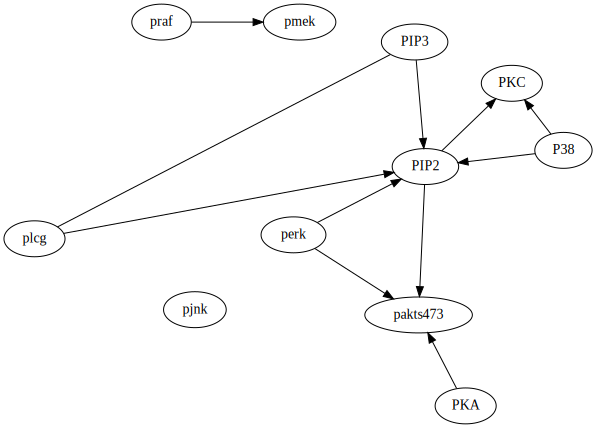

In [27]:
# Experiments 1 and 5 together

data_exp1_5_drop = data_exp1_5.drop(columns='experiment')
tester1_5 = IndependenceTester(data_exp1_5_drop, ParCorr(), alpha=0.2)

G = PC_algorithm(11, tester1_5)
graph_to_graphviz(G, list(data_exp1_5_drop.columns))

**Question**: In the dataframe for experiments 1 and 6, look at pmek, perk, and any other variables you think might be relevant. Assume it is true that adding U0126 produces an intervention on the activity of pmek. What would you expect to see in the data if the graph found by PC was correct? What changes would you propose to that graph based on the data?

Again put your answer with accompanying plots in new boxes below here.

**Answer**: One thing we might expect to see is more connectedness around pmek. This does seem to be the case. However, when consulting the graph resulting from experiments 1 and 6, it appears that pmek is a child of perk rather than the other way around. perk has changed, as it is now the parent of praf, pmek and PKC, which does fall in line with expectations from the data. If this graph is correct, an intervention on pmek would influence the structural graph of perk. In the actual graph, however, much more changes, which makes it difficult to thorougly gauge the effects of the intervention. Additionally, if the true causal model perk is a child of pmek, that should be reflected in the graphs, which currently is not the case.

test: 0 and 1 given () -> pval=0.0
test: 0 and 2 given () -> pval=0.22579211347507994
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.03332165389820263
test: 0 and 4 given () -> pval=0.0018048301566494169
test: 0 and 5 given () -> pval=2.4846295816511114e-70
test: 0 and 6 given () -> pval=1.795947241414922e-29
test: 0 and 7 given () -> pval=6.091908195017966e-12
test: 0 and 8 given () -> pval=4.579202937137639e-62
test: 0 and 9 given () -> pval=0.016423604063641198
test: 0 and 10 given () -> pval=5.139426589447728e-26
test: 1 and 0 given () -> pval=0.0
test: 1 and 2 given () -> pval=0.10463195222143483
independence found: 1 and 2 given ()
test: 1 and 3 given () -> pval=0.02337330991619621
test: 1 and 4 given () -> pval=0.0007183354978785982
test: 1 and 5 given () -> pval=1.491894310801781e-110
test: 1 and 6 given () -> pval=4.1379458633678395e-49
test: 1 and 7 given () -> pval=2.0093199621435567e-18
test: 1 and 8 given () -> pval=1.6347190760257162e-95
test: 1 and

test: 4 and 3 given (10,) -> pval=2.121335601147102e-70
test: 4 and 5 given (0,) -> pval=0.271738780595532
independence found: 4 and 5 given (0,)
test: 4 and 7 given (0,) -> pval=0.03826247673013286
test: 4 and 7 given (1,) -> pval=0.05871583817516737
test: 4 and 7 given (2,) -> pval=0.01247285214372722
test: 4 and 7 given (3,) -> pval=0.08177978479118823
test: 4 and 7 given (5,) -> pval=0.1537027677291096
independence found: 4 and 7 given (5,)
test: 4 and 8 given (0,) -> pval=0.04813377223194608
test: 4 and 8 given (1,) -> pval=0.1050093839795673
independence found: 4 and 8 given (1,)
test: 4 and 10 given (0,) -> pval=0.09422447109224832
test: 4 and 10 given (1,) -> pval=0.16938036587562594
independence found: 4 and 10 given (1,)
test: 5 and 0 given (1,) -> pval=7.775564356882014e-14
test: 5 and 0 given (2,) -> pval=5.08340204799932e-70
test: 5 and 0 given (3,) -> pval=1.0713660710063662e-69
test: 5 and 0 given (4,) -> pval=2.0962123918131258e-69
test: 5 and 0 given (6,) -> pval=3.598

test: 9 and 10 given (6,) -> pval=2.8877432040748705e-18
test: 9 and 10 given (7,) -> pval=1.273589389958279e-17
test: 9 and 10 given (8,) -> pval=0.07682353901653789
test: 10 and 0 given (1,) -> pval=1.5085719195881846e-09
test: 10 and 0 given (2,) -> pval=7.702251611944243e-26
test: 10 and 0 given (3,) -> pval=1.2861258143381675e-25
test: 10 and 0 given (4,) -> pval=2.4262263286221474e-25
test: 10 and 0 given (5,) -> pval=1.8183841756332275e-12
test: 10 and 0 given (6,) -> pval=1.446907991584047e-19
test: 10 and 0 given (7,) -> pval=1.3083701633685988e-23
test: 10 and 0 given (8,) -> pval=1.513422150513607e-08
test: 10 and 0 given (9,) -> pval=9.463814226002236e-25
test: 10 and 1 given (0,) -> pval=4.342835262144796e-27
test: 10 and 1 given (2,) -> pval=3.776639289890145e-43
test: 10 and 1 given (3,) -> pval=6.4471930633960395e-43
test: 10 and 1 given (4,) -> pval=1.4752295242851722e-42
test: 10 and 1 given (5,) -> pval=7.234793733116622e-24
test: 10 and 1 given (6,) -> pval=4.558215

test: 0 and 10 given (4, 8) -> pval=2.2273572172512455e-08
test: 0 and 10 given (4, 9) -> pval=3.472700644749368e-24
test: 0 and 10 given (5, 6) -> pval=0.0001082404090779158
test: 0 and 10 given (5, 7) -> pval=2.1722322973122395e-11
test: 0 and 10 given (5, 8) -> pval=4.0763872220699796e-05
test: 0 and 10 given (5, 9) -> pval=8.186839667587874e-12
test: 0 and 10 given (6, 7) -> pval=1.5350730549262603e-13
test: 0 and 10 given (6, 8) -> pval=8.854789890594541e-07
test: 0 and 10 given (6, 9) -> pval=2.1229628542971283e-18
test: 0 and 10 given (7, 8) -> pval=3.956588482631918e-08
test: 0 and 10 given (7, 9) -> pval=1.3369415145407546e-22
test: 0 and 10 given (8, 9) -> pval=1.1750809624777413e-09
test: 1 and 0 given (2, 3) -> pval=0.0
test: 1 and 0 given (2, 4) -> pval=0.0
test: 1 and 0 given (2, 5) -> pval=0.0
test: 1 and 0 given (2, 6) -> pval=0.0
test: 1 and 0 given (2, 7) -> pval=0.0
test: 1 and 0 given (2, 8) -> pval=0.0
test: 1 and 0 given (2, 9) -> pval=0.0
test: 1 and 0 given (2, 

test: 2 and 3 given (6, 10) -> pval=7.228695237246471e-06
test: 2 and 3 given (7, 8) -> pval=1.0648238492711911e-05
test: 2 and 3 given (7, 9) -> pval=6.742108179848278e-06
test: 2 and 3 given (7, 10) -> pval=8.421612006536877e-06
test: 2 and 3 given (8, 9) -> pval=9.817386254360078e-06
test: 2 and 3 given (8, 10) -> pval=1.0752046818735874e-05
test: 2 and 3 given (9, 10) -> pval=7.304813915410784e-06
test: 3 and 2 given (0, 1) -> pval=7.678129635605048e-06
test: 3 and 2 given (0, 4) -> pval=0.0005847524970037345
test: 3 and 2 given (0, 5) -> pval=8.596280902333427e-06
test: 3 and 2 given (0, 6) -> pval=6.89289960241476e-06
test: 3 and 2 given (0, 7) -> pval=7.847741381273e-06
test: 3 and 2 given (0, 8) -> pval=1.0215535070261938e-05
test: 3 and 2 given (0, 9) -> pval=7.160147386310984e-06
test: 3 and 2 given (0, 10) -> pval=8.395176056524392e-06
test: 3 and 2 given (1, 4) -> pval=0.0006043399488674908
test: 3 and 2 given (1, 5) -> pval=8.98633141641372e-06
test: 3 and 2 given (1, 6) -

test: 5 and 7 given (2, 6) -> pval=7.669345095769946e-179
test: 5 and 7 given (2, 8) -> pval=2.8972446055747486e-180
test: 5 and 7 given (2, 9) -> pval=5.229021789765422e-188
test: 5 and 7 given (2, 10) -> pval=6.179409469883216e-187
test: 5 and 7 given (3, 4) -> pval=2.0878724901741067e-187
test: 5 and 7 given (3, 6) -> pval=3.085261576744484e-178
test: 5 and 7 given (3, 8) -> pval=5.702988982477546e-180
test: 5 and 7 given (3, 9) -> pval=2.6075131912684216e-187
test: 5 and 7 given (3, 10) -> pval=2.0257968678551447e-186
test: 5 and 7 given (4, 6) -> pval=7.133838383447373e-178
test: 5 and 7 given (4, 8) -> pval=5.895651257751128e-180
test: 5 and 7 given (4, 9) -> pval=3.3725820358470334e-187
test: 5 and 7 given (4, 10) -> pval=2.2105477628351305e-186
test: 5 and 7 given (6, 8) -> pval=2.87964329236287e-151
test: 5 and 7 given (6, 9) -> pval=2.50271254083961e-178
test: 5 and 7 given (6, 10) -> pval=3.758038361064449e-168
test: 5 and 7 given (8, 9) -> pval=3.3040469093936623e-181
test:

test: 6 and 8 given (4, 10) -> pval=4.0916903448184237e-13
test: 6 and 8 given (5, 7) -> pval=1.5479850370443615e-36
test: 6 and 8 given (5, 9) -> pval=8.200897407856853e-51
test: 6 and 8 given (5, 10) -> pval=1.2285073181476133e-28
test: 6 and 8 given (7, 9) -> pval=2.9995502952829205e-45
test: 6 and 8 given (7, 10) -> pval=2.6815094529241864e-25
test: 6 and 8 given (9, 10) -> pval=1.1648555037101812e-18
test: 6 and 10 given (0, 1) -> pval=0.09674953385780168
test: 6 and 10 given (0, 2) -> pval=7.659996775512194e-06
test: 6 and 10 given (0, 3) -> pval=6.23502491414189e-06
test: 6 and 10 given (0, 4) -> pval=7.42533284603118e-06
test: 6 and 10 given (0, 5) -> pval=8.423082241875703e-13
test: 6 and 10 given (0, 7) -> pval=1.4629870230973279e-09
test: 6 and 10 given (0, 8) -> pval=0.001700871437772925
test: 6 and 10 given (0, 9) -> pval=4.411591683517786e-06
test: 6 and 10 given (1, 2) -> pval=0.010284593009769317
test: 6 and 10 given (1, 3) -> pval=0.009149853585236187
test: 6 and 10 gi

test: 8 and 6 given (0, 1) -> pval=0.07931751013830812
test: 8 and 6 given (0, 2) -> pval=7.97019653210673e-08
test: 8 and 6 given (0, 3) -> pval=5.678688479513349e-08
test: 8 and 6 given (0, 4) -> pval=7.68928477457802e-08
test: 8 and 6 given (0, 5) -> pval=1.1381142233790719e-21
test: 8 and 6 given (0, 7) -> pval=3.693108090738293e-16
test: 8 and 6 given (0, 9) -> pval=1.487186285317575e-10
test: 8 and 6 given (0, 10) -> pval=1.6207664414693493e-05
test: 8 and 6 given (1, 2) -> pval=0.006162531172993583
test: 8 and 6 given (1, 3) -> pval=0.0051759466629896595
test: 8 and 6 given (1, 4) -> pval=0.00598785856693982
test: 8 and 6 given (1, 5) -> pval=1.0357059084778955e-10
test: 8 and 6 given (1, 7) -> pval=1.3281549291728018e-06
test: 8 and 6 given (1, 9) -> pval=0.0005767573259091584
test: 8 and 6 given (1, 10) -> pval=0.027247958004702328
test: 8 and 6 given (2, 3) -> pval=2.654640540232426e-20
test: 8 and 6 given (2, 4) -> pval=5.542143388275242e-20
test: 8 and 6 given (2, 5) -> pva

test: 10 and 1 given (6, 7) -> pval=7.425628211868635e-25
test: 10 and 1 given (6, 8) -> pval=2.1223080931928308e-13
test: 10 and 1 given (6, 9) -> pval=4.938181768329132e-33
test: 10 and 1 given (7, 8) -> pval=9.032361086063115e-16
test: 10 and 1 given (7, 9) -> pval=2.0909446751442218e-39
test: 10 and 1 given (8, 9) -> pval=2.669234469106449e-19
test: 10 and 5 given (0, 1) -> pval=0.0027381533118040246
test: 10 and 5 given (0, 2) -> pval=4.359842419194933e-11
test: 10 and 5 given (0, 3) -> pval=4.5805371706276545e-11
test: 10 and 5 given (0, 4) -> pval=4.338506734310728e-11
test: 10 and 5 given (0, 6) -> pval=4.357483700739084e-18
test: 10 and 5 given (0, 7) -> pval=7.938682949502272e-11
test: 10 and 5 given (0, 8) -> pval=4.0065197154038534e-05
test: 10 and 5 given (0, 9) -> pval=5.789600048406981e-11
test: 10 and 5 given (1, 2) -> pval=6.6661653706049e-05
test: 10 and 5 given (1, 3) -> pval=6.909465973962374e-05
test: 10 and 5 given (1, 4) -> pval=6.450447189914215e-05
test: 10 and

test: 0 and 5 given (1, 2, 9) -> pval=7.72363020369737e-14
test: 0 and 5 given (1, 2, 10) -> pval=3.3994407895728907e-12
test: 0 and 5 given (1, 3, 4) -> pval=7.762261335547553e-14
test: 0 and 5 given (1, 3, 6) -> pval=1.428788703399003e-31
test: 0 and 5 given (1, 3, 7) -> pval=5.493529132502813e-12
test: 0 and 5 given (1, 3, 8) -> pval=5.896989263932106e-11
test: 0 and 5 given (1, 3, 9) -> pval=6.449592470334903e-14
test: 0 and 5 given (1, 3, 10) -> pval=2.8594912257286587e-12
test: 0 and 5 given (1, 4, 6) -> pval=1.425863335750518e-31
test: 0 and 5 given (1, 4, 7) -> pval=5.5221002756866066e-12
test: 0 and 5 given (1, 4, 8) -> pval=6.207654412111692e-11
test: 0 and 5 given (1, 4, 9) -> pval=6.677008931421362e-14
test: 0 and 5 given (1, 4, 10) -> pval=3.005148214141204e-12
test: 0 and 5 given (1, 6, 7) -> pval=8.749965002018024e-21
test: 0 and 5 given (1, 6, 8) -> pval=1.6639980124396855e-26
test: 0 and 5 given (1, 6, 9) -> pval=1.0319689454706295e-31
test: 0 and 5 given (1, 6, 10) ->

test: 0 and 8 given (2, 4, 5) -> pval=4.82202560888981e-31
test: 0 and 8 given (2, 4, 6) -> pval=1.1587019382936898e-48
test: 0 and 8 given (2, 4, 7) -> pval=4.9934259291188174e-55
test: 0 and 8 given (2, 4, 9) -> pval=3.973473721153667e-71
test: 0 and 8 given (2, 4, 10) -> pval=5.849142434911918e-44
test: 0 and 8 given (2, 5, 6) -> pval=4.999401322950741e-14
test: 0 and 8 given (2, 5, 7) -> pval=9.381359743369697e-30
test: 0 and 8 given (2, 5, 9) -> pval=3.5666687053194424e-37
test: 0 and 8 given (2, 5, 10) -> pval=2.1184063761500176e-24
test: 0 and 8 given (2, 6, 7) -> pval=3.509278828960818e-35
test: 0 and 8 given (2, 6, 9) -> pval=1.6088082116410113e-57
test: 0 and 8 given (2, 6, 10) -> pval=3.886967335493363e-37
test: 0 and 8 given (2, 7, 9) -> pval=7.737398159806378e-66
test: 0 and 8 given (2, 7, 10) -> pval=1.2116640538541946e-40
test: 0 and 8 given (2, 9, 10) -> pval=2.82477921695661e-57
test: 0 and 8 given (3, 4, 5) -> pval=5.006857354892776e-31
test: 0 and 8 given (3, 4, 6) -

test: 1 and 0 given (5, 6, 9) -> pval=0.0
test: 1 and 0 given (5, 6, 10) -> pval=0.0
test: 1 and 0 given (5, 7, 8) -> pval=0.0
test: 1 and 0 given (5, 7, 9) -> pval=0.0
test: 1 and 0 given (5, 7, 10) -> pval=0.0
test: 1 and 0 given (5, 8, 9) -> pval=0.0
test: 1 and 0 given (5, 8, 10) -> pval=0.0
test: 1 and 0 given (5, 9, 10) -> pval=0.0
test: 1 and 0 given (6, 7, 8) -> pval=0.0
test: 1 and 0 given (6, 7, 9) -> pval=0.0
test: 1 and 0 given (6, 7, 10) -> pval=0.0
test: 1 and 0 given (6, 8, 9) -> pval=0.0
test: 1 and 0 given (6, 8, 10) -> pval=0.0
test: 1 and 0 given (6, 9, 10) -> pval=0.0
test: 1 and 0 given (7, 8, 9) -> pval=0.0
test: 1 and 0 given (7, 8, 10) -> pval=0.0
test: 1 and 0 given (7, 9, 10) -> pval=0.0
test: 1 and 0 given (8, 9, 10) -> pval=0.0
test: 1 and 5 given (0, 2, 3) -> pval=7.277939776515021e-54
test: 1 and 5 given (0, 2, 4) -> pval=8.257185104355436e-54
test: 1 and 5 given (0, 2, 6) -> pval=3.3169236903720916e-107
test: 1 and 5 given (0, 2, 7) -> pval=2.720248332490

test: 1 and 8 given (0, 3, 5) -> pval=3.9479541060996796e-29
test: 1 and 8 given (0, 3, 6) -> pval=9.08416670928029e-39
test: 1 and 8 given (0, 3, 7) -> pval=2.899388448311596e-41
test: 1 and 8 given (0, 3, 9) -> pval=1.3897920071157586e-62
test: 1 and 8 given (0, 3, 10) -> pval=6.930134219495168e-32
test: 1 and 8 given (0, 4, 5) -> pval=5.474930328791634e-29
test: 1 and 8 given (0, 4, 6) -> pval=1.0105366695386166e-38
test: 1 and 8 given (0, 4, 7) -> pval=3.874062043332198e-41
test: 1 and 8 given (0, 4, 9) -> pval=1.766283770378348e-62
test: 1 and 8 given (0, 4, 10) -> pval=8.657957559025153e-32
test: 1 and 8 given (0, 5, 6) -> pval=4.634248810737839e-15
test: 1 and 8 given (0, 5, 7) -> pval=2.035700381291636e-28
test: 1 and 8 given (0, 5, 9) -> pval=9.159495543302307e-43
test: 1 and 8 given (0, 5, 10) -> pval=3.908561919430226e-21
test: 1 and 8 given (0, 6, 7) -> pval=1.2695627987036812e-29
test: 1 and 8 given (0, 6, 9) -> pval=7.747575944434219e-55
test: 1 and 8 given (0, 6, 10) -> 

test: 2 and 3 given (0, 6, 10) -> pval=8.603085476309767e-06
test: 2 and 3 given (0, 7, 8) -> pval=1.1057839861012793e-05
test: 2 and 3 given (0, 7, 9) -> pval=8.159883334945276e-06
test: 2 and 3 given (0, 7, 10) -> pval=9.404367574614794e-06
test: 2 and 3 given (0, 8, 9) -> pval=1.0148187915576796e-05
test: 2 and 3 given (0, 8, 10) -> pval=1.1113228030750354e-05
test: 2 and 3 given (0, 9, 10) -> pval=8.478779596675184e-06
test: 2 and 3 given (1, 4, 5) -> pval=0.0006680267619750146
test: 2 and 3 given (1, 4, 6) -> pval=0.0006221514954127543
test: 2 and 3 given (1, 4, 7) -> pval=0.0006293162211098503
test: 2 and 3 given (1, 4, 8) -> pval=0.0007144632262295126
test: 2 and 3 given (1, 4, 9) -> pval=0.0006136037024045174
test: 2 and 3 given (1, 4, 10) -> pval=0.0006482501149005293
test: 2 and 3 given (1, 5, 6) -> pval=8.756536829171465e-06
test: 2 and 3 given (1, 5, 7) -> pval=8.478431996492893e-06
test: 2 and 3 given (1, 5, 8) -> pval=1.154493714833031e-05
test: 2 and 3 given (1, 5, 9) ->

test: 3 and 4 given (5, 6, 8) -> pval=9.154891708929855e-70
test: 3 and 4 given (5, 6, 9) -> pval=3.709877623202307e-70
test: 3 and 4 given (5, 6, 10) -> pval=4.91764172060157e-70
test: 3 and 4 given (5, 7, 8) -> pval=2.339423368210379e-69
test: 3 and 4 given (5, 7, 9) -> pval=7.518933018675789e-70
test: 3 and 4 given (5, 7, 10) -> pval=1.1769614678520392e-69
test: 3 and 4 given (5, 8, 9) -> pval=1.186708770278253e-69
test: 3 and 4 given (5, 8, 10) -> pval=1.6884576174618722e-69
test: 3 and 4 given (5, 9, 10) -> pval=8.457978625586047e-70
test: 3 and 4 given (6, 7, 8) -> pval=1.729702181093637e-69
test: 3 and 4 given (6, 7, 9) -> pval=5.814328112192555e-70
test: 3 and 4 given (6, 7, 10) -> pval=9.165701661715772e-70
test: 3 and 4 given (6, 8, 9) -> pval=6.373169952770186e-70
test: 3 and 4 given (6, 8, 10) -> pval=1.0996577471159836e-69
test: 3 and 4 given (6, 9, 10) -> pval=2.7799413424418755e-70
test: 3 and 4 given (7, 8, 9) -> pval=2.342259476711383e-69
test: 3 and 4 given (7, 8, 10)

test: 5 and 1 given (2, 4, 7) -> pval=7.695967654757417e-104
test: 5 and 1 given (2, 4, 8) -> pval=3.886051698312284e-67
test: 5 and 1 given (2, 4, 9) -> pval=2.0889409543588767e-108
test: 5 and 1 given (2, 4, 10) -> pval=3.8606629473370607e-90
test: 5 and 1 given (2, 6, 7) -> pval=1.943191469880102e-120
test: 5 and 1 given (2, 6, 8) -> pval=1.9990663248562243e-121
test: 5 and 1 given (2, 6, 9) -> pval=1.3654841206960752e-174
test: 5 and 1 given (2, 6, 10) -> pval=7.387695914982006e-152
test: 5 and 1 given (2, 7, 8) -> pval=2.3180785284452018e-67
test: 5 and 1 given (2, 7, 9) -> pval=1.407727126584933e-103
test: 5 and 1 given (2, 7, 10) -> pval=2.7907435340460323e-86
test: 5 and 1 given (2, 8, 9) -> pval=1.1527850408708044e-58
test: 5 and 1 given (2, 8, 10) -> pval=6.426196478644236e-62
test: 5 and 1 given (2, 9, 10) -> pval=1.1255804696891794e-90
test: 5 and 1 given (3, 4, 6) -> pval=2.4925794348456894e-174
test: 5 and 1 given (3, 4, 7) -> pval=4.5656564189698374e-104
test: 5 and 1 gi

test: 5 and 10 given (0, 2, 8) -> pval=4.364483311151272e-05
test: 5 and 10 given (0, 2, 9) -> pval=7.522877285091453e-11
test: 5 and 10 given (0, 3, 4) -> pval=5.0547475613408545e-11
test: 5 and 10 given (0, 3, 6) -> pval=6.1581712313945845e-18
test: 5 and 10 given (0, 3, 7) -> pval=8.184507151897105e-11
test: 5 and 10 given (0, 3, 8) -> pval=4.401822331898254e-05
test: 5 and 10 given (0, 3, 9) -> pval=7.597041598524508e-11
test: 5 and 10 given (0, 4, 6) -> pval=6.164152804800691e-18
test: 5 and 10 given (0, 4, 7) -> pval=7.250067664081887e-11
test: 5 and 10 given (0, 4, 8) -> pval=4.3192247302223475e-05
test: 5 and 10 given (0, 4, 9) -> pval=7.24929805573765e-11
test: 5 and 10 given (0, 6, 7) -> pval=4.955434576587866e-13
test: 5 and 10 given (0, 6, 8) -> pval=9.8849302062367e-09
test: 5 and 10 given (0, 6, 9) -> pval=6.395232774358277e-18
test: 5 and 10 given (0, 7, 8) -> pval=1.8957993810267876e-05
test: 5 and 10 given (0, 7, 9) -> pval=4.52569352556912e-11
test: 5 and 10 given (0,

test: 6 and 1 given (7, 8, 10) -> pval=9.891887105404753e-53
test: 6 and 1 given (7, 9, 10) -> pval=1.968816451118949e-72
test: 6 and 1 given (8, 9, 10) -> pval=9.495999399025362e-25
test: 6 and 7 given (0, 1, 2) -> pval=3.6602966401536925e-93
test: 6 and 7 given (0, 1, 3) -> pval=7.738114911724111e-93
test: 6 and 7 given (0, 1, 4) -> pval=3.6480351159051027e-93
test: 6 and 7 given (0, 1, 5) -> pval=1.5893685681759273e-25
test: 6 and 7 given (0, 1, 8) -> pval=2.5130265839595676e-95
test: 6 and 7 given (0, 1, 9) -> pval=2.8672256288310426e-93
test: 6 and 7 given (0, 1, 10) -> pval=8.027424425642816e-94
test: 6 and 7 given (0, 2, 3) -> pval=1.1282863563350071e-66
test: 6 and 7 given (0, 2, 4) -> pval=4.966058597633557e-67
test: 6 and 7 given (0, 2, 5) -> pval=1.473256932761715e-29
test: 6 and 7 given (0, 2, 8) -> pval=4.329802494604972e-75
test: 6 and 7 given (0, 2, 9) -> pval=5.7360843918593915e-67
test: 6 and 7 given (0, 2, 10) -> pval=1.6345787505135586e-70
test: 6 and 7 given (0, 3, 

test: 7 and 6 given (2, 4, 8) -> pval=5.32644641498229e-63
test: 7 and 6 given (2, 4, 9) -> pval=8.064714242251127e-47
test: 7 and 6 given (2, 4, 10) -> pval=1.4795596802238126e-53
test: 7 and 6 given (2, 5, 8) -> pval=1.0461574616958744e-33
test: 7 and 6 given (2, 5, 9) -> pval=1.909616155690016e-36
test: 7 and 6 given (2, 5, 10) -> pval=2.719579832089478e-34
test: 7 and 6 given (2, 8, 9) -> pval=3.2630098695074547e-66
test: 7 and 6 given (2, 8, 10) -> pval=2.8055109229911384e-65
test: 7 and 6 given (2, 9, 10) -> pval=3.7270978382441003e-53
test: 7 and 6 given (3, 4, 5) -> pval=1.2960270886281114e-36
test: 7 and 6 given (3, 4, 8) -> pval=7.871692371485487e-63
test: 7 and 6 given (3, 4, 9) -> pval=1.1748705400088112e-46
test: 7 and 6 given (3, 4, 10) -> pval=2.1887659505859367e-53
test: 7 and 6 given (3, 5, 8) -> pval=1.3385571208769228e-33
test: 7 and 6 given (3, 5, 9) -> pval=1.7702876279637926e-36
test: 7 and 6 given (3, 5, 10) -> pval=2.951983901618925e-34
test: 7 and 6 given (3, 8

test: 8 and 5 given (1, 7, 10) -> pval=1.6718910230556446e-07
test: 8 and 5 given (1, 9, 10) -> pval=1.2869379642833517e-12
test: 8 and 5 given (2, 3, 4) -> pval=1.817356822182695e-53
test: 8 and 5 given (2, 3, 6) -> pval=1.173331976988166e-72
test: 8 and 5 given (2, 3, 7) -> pval=6.185528741041607e-46
test: 8 and 5 given (2, 3, 9) -> pval=3.068313520807458e-64
test: 8 and 5 given (2, 3, 10) -> pval=3.0842773594570995e-38
test: 8 and 5 given (2, 4, 6) -> pval=1.7280647664403534e-72
test: 8 and 5 given (2, 4, 7) -> pval=6.233978468387368e-46
test: 8 and 5 given (2, 4, 9) -> pval=3.850595197481939e-64
test: 8 and 5 given (2, 4, 10) -> pval=3.379334726437675e-38
test: 8 and 5 given (2, 6, 7) -> pval=1.1824012321090077e-45
test: 8 and 5 given (2, 6, 9) -> pval=3.887106520104704e-90
test: 8 and 5 given (2, 6, 10) -> pval=6.54016827250821e-54
test: 8 and 5 given (2, 7, 9) -> pval=6.406413673946345e-58
test: 8 and 5 given (2, 7, 10) -> pval=3.520835481184343e-32
test: 8 and 5 given (2, 9, 10)

test: 9 and 8 given (2, 3, 4) -> pval=2.4762141744329093e-109
test: 9 and 8 given (2, 3, 5) -> pval=5.221741031543481e-120
test: 9 and 8 given (2, 3, 6) -> pval=1.0086857584575147e-114
test: 9 and 8 given (2, 3, 7) -> pval=5.413801057274382e-110
test: 9 and 8 given (2, 3, 10) -> pval=3.9981160998534324e-94
test: 9 and 8 given (2, 4, 5) -> pval=6.771489681761872e-120
test: 9 and 8 given (2, 4, 6) -> pval=1.3553586069605922e-114
test: 9 and 8 given (2, 4, 7) -> pval=7.05914079058919e-110
test: 9 and 8 given (2, 4, 10) -> pval=4.579533914198229e-94
test: 9 and 8 given (2, 5, 6) -> pval=6.65315265234151e-132
test: 9 and 8 given (2, 5, 7) -> pval=3.7004492877450967e-122
test: 9 and 8 given (2, 5, 10) -> pval=1.440018224508753e-106
test: 9 and 8 given (2, 6, 7) -> pval=1.4027867172838163e-118
test: 9 and 8 given (2, 6, 10) -> pval=8.688815161760127e-100
test: 9 and 8 given (2, 7, 10) -> pval=3.072811846942101e-95
test: 9 and 8 given (3, 4, 5) -> pval=1.026500994762266e-119
test: 9 and 8 give

test: 10 and 1 given (2, 7, 8) -> pval=9.999732772588308e-16
test: 10 and 1 given (2, 7, 9) -> pval=3.570193568858257e-39
test: 10 and 1 given (2, 8, 9) -> pval=2.95139099306007e-19
test: 10 and 1 given (3, 4, 5) -> pval=2.0711126115583496e-23
test: 10 and 1 given (3, 4, 6) -> pval=4.103782151865514e-33
test: 10 and 1 given (3, 4, 7) -> pval=2.623654254193363e-39
test: 10 and 1 given (3, 4, 8) -> pval=3.5067212044668366e-16
test: 10 and 1 given (3, 4, 9) -> pval=1.4960517733767772e-41
test: 10 and 1 given (3, 5, 6) -> pval=6.19678375390984e-10
test: 10 and 1 given (3, 5, 7) -> pval=5.2229767047772325e-22
test: 10 and 1 given (3, 5, 8) -> pval=8.991321975784061e-11
test: 10 and 1 given (3, 5, 9) -> pval=2.452175390767479e-23
test: 10 and 1 given (3, 6, 7) -> pval=1.4937611717459692e-24
test: 10 and 1 given (3, 6, 8) -> pval=2.862761047415884e-13
test: 10 and 1 given (3, 6, 9) -> pval=1.5005098275676926e-32
test: 10 and 1 given (3, 7, 8) -> pval=1.0565322621638804e-15
test: 10 and 1 give

test: 10 and 9 given (1, 4, 6) -> pval=4.43344325187089e-17
test: 10 and 9 given (1, 4, 7) -> pval=7.845795702199412e-17
test: 10 and 9 given (1, 4, 8) -> pval=6.066657782806147e-05
test: 10 and 9 given (1, 5, 6) -> pval=4.853233803739766e-17
test: 10 and 9 given (1, 5, 7) -> pval=4.719291579270042e-17
test: 10 and 9 given (1, 5, 8) -> pval=2.0220021233839837e-05
test: 10 and 9 given (1, 6, 7) -> pval=5.890327278574419e-17
test: 10 and 9 given (1, 6, 8) -> pval=3.489859845985713e-05
test: 10 and 9 given (1, 7, 8) -> pval=5.456298176895988e-05
test: 10 and 9 given (2, 3, 4) -> pval=9.437229948011894e-18
test: 10 and 9 given (2, 3, 5) -> pval=4.154464223002226e-17
test: 10 and 9 given (2, 3, 6) -> pval=5.135671912051759e-18
test: 10 and 9 given (2, 3, 7) -> pval=2.007424437129615e-17
test: 10 and 9 given (2, 3, 8) -> pval=0.07413624716570771
test: 10 and 9 given (2, 4, 5) -> pval=4.807746092146684e-17
test: 10 and 9 given (2, 4, 6) -> pval=5.842681400472847e-18
test: 10 and 9 given (2, 4

test: 0 and 5 given (2, 3, 7, 8) -> pval=1.1187484947813394e-40
test: 0 and 5 given (2, 3, 7, 9) -> pval=2.5781340677675673e-66
test: 0 and 5 given (2, 3, 7, 10) -> pval=1.1202854015179213e-54
test: 0 and 5 given (2, 3, 8, 9) -> pval=2.4832781258847833e-34
test: 0 and 5 given (2, 3, 8, 10) -> pval=2.008757986387054e-36
test: 0 and 5 given (2, 3, 9, 10) -> pval=2.359775885612441e-56
test: 0 and 5 given (2, 4, 6, 7) -> pval=6.846679268570562e-69
test: 0 and 5 given (2, 4, 6, 8) -> pval=4.7087680916257555e-64
test: 0 and 5 given (2, 4, 6, 9) -> pval=3.9125949264435345e-98
test: 0 and 5 given (2, 4, 6, 10) -> pval=9.849866231513067e-85
test: 0 and 5 given (2, 4, 7, 8) -> pval=8.948851031445898e-41
test: 0 and 5 given (2, 4, 7, 9) -> pval=2.4104280664963595e-66
test: 0 and 5 given (2, 4, 7, 10) -> pval=9.140822296635788e-55
test: 0 and 5 given (2, 4, 8, 9) -> pval=3.2125188193436497e-34
test: 0 and 5 given (2, 4, 8, 10) -> pval=2.4054125688148426e-36
test: 0 and 5 given (2, 4, 9, 10) -> pva

test: 0 and 8 given (1, 3, 4, 10) -> pval=6.870938431561976e-08
test: 0 and 8 given (1, 3, 5, 6) -> pval=8.105423319660278e-05
test: 0 and 8 given (1, 3, 5, 7) -> pval=5.158722006129743e-08
test: 0 and 8 given (1, 3, 5, 9) -> pval=2.2712993538593358e-13
test: 0 and 8 given (1, 3, 5, 10) -> pval=7.829965985773246e-06
test: 0 and 8 given (1, 3, 6, 7) -> pval=5.631048623578452e-08
test: 0 and 8 given (1, 3, 6, 9) -> pval=7.984807931068658e-16
test: 0 and 8 given (1, 3, 6, 10) -> pval=3.086060609463879e-07
test: 0 and 8 given (1, 3, 7, 9) -> pval=1.3893648551766688e-16
test: 0 and 8 given (1, 3, 7, 10) -> pval=2.273095915655379e-07
test: 0 and 8 given (1, 3, 9, 10) -> pval=8.463276795079424e-15
test: 0 and 8 given (1, 4, 5, 6) -> pval=8.208110959205256e-05
test: 0 and 8 given (1, 4, 5, 7) -> pval=5.5117467973569164e-08
test: 0 and 8 given (1, 4, 5, 9) -> pval=2.4441488375340614e-13
test: 0 and 8 given (1, 4, 5, 10) -> pval=8.23115410429299e-06
test: 0 and 8 given (1, 4, 6, 7) -> pval=5.636

test: 0 and 10 given (4, 5, 7, 8) -> pval=0.00013994269657592728
test: 0 and 10 given (4, 5, 7, 9) -> pval=2.0877901834474972e-10
test: 0 and 10 given (4, 5, 8, 9) -> pval=7.645917411290484e-06
test: 0 and 10 given (4, 6, 7, 8) -> pval=3.1972016008102875e-05
test: 0 and 10 given (4, 6, 7, 9) -> pval=1.3765328475094398e-12
test: 0 and 10 given (4, 6, 8, 9) -> pval=1.2236693426013472e-07
test: 0 and 10 given (4, 7, 8, 9) -> pval=4.589645389177035e-09
test: 0 and 10 given (5, 6, 7, 8) -> pval=0.02465727325674879
test: 0 and 10 given (5, 6, 7, 9) -> pval=0.0002893962916693203
test: 0 and 10 given (5, 6, 8, 9) -> pval=0.009415405989235586
test: 0 and 10 given (5, 7, 8, 9) -> pval=1.7879689375023747e-05
test: 0 and 10 given (6, 7, 8, 9) -> pval=3.3598282675937673e-06
test: 1 and 0 given (2, 3, 4, 5) -> pval=0.0
test: 1 and 0 given (2, 3, 4, 6) -> pval=0.0
test: 1 and 0 given (2, 3, 4, 7) -> pval=0.0
test: 1 and 0 given (2, 3, 4, 8) -> pval=0.0
test: 1 and 0 given (2, 3, 4, 9) -> pval=0.0
tes

test: 1 and 5 given (3, 4, 6, 8) -> pval=4.590287753217747e-121
test: 1 and 5 given (3, 4, 6, 9) -> pval=1.4911865118082463e-173
test: 1 and 5 given (3, 4, 6, 10) -> pval=3.4056612028605564e-151
test: 1 and 5 given (3, 4, 7, 8) -> pval=1.42145035693395e-67
test: 1 and 5 given (3, 4, 7, 9) -> pval=9.043657678050635e-104
test: 1 and 5 given (3, 4, 7, 10) -> pval=1.5840711869366088e-86
test: 1 and 5 given (3, 4, 8, 9) -> pval=2.2735712705725115e-58
test: 1 and 5 given (3, 4, 8, 10) -> pval=9.965590350727998e-62
test: 1 and 5 given (3, 4, 9, 10) -> pval=3.539613765880369e-90
test: 1 and 5 given (3, 6, 7, 8) -> pval=2.926495678410813e-88
test: 1 and 5 given (3, 6, 7, 9) -> pval=2.475325659053527e-120
test: 1 and 5 given (3, 6, 7, 10) -> pval=4.283186388657141e-106
test: 1 and 5 given (3, 6, 8, 9) -> pval=1.0402252154586813e-108
test: 1 and 5 given (3, 6, 8, 10) -> pval=1.913483740064281e-113
test: 1 and 5 given (3, 6, 9, 10) -> pval=1.512729292573327e-151
test: 1 and 5 given (3, 7, 8, 9) ->

test: 1 and 8 given (2, 3, 7, 9) -> pval=1.9595826313408897e-107
test: 1 and 8 given (2, 3, 7, 10) -> pval=3.2144766416658804e-62
test: 1 and 8 given (2, 3, 9, 10) -> pval=8.348115403452766e-94
test: 1 and 8 given (2, 4, 5, 6) -> pval=1.1294800263924518e-23
test: 1 and 8 given (2, 4, 5, 7) -> pval=3.662980785086389e-49
test: 1 and 8 given (2, 4, 5, 9) -> pval=7.942127810421761e-66
test: 1 and 8 given (2, 4, 5, 10) -> pval=4.4588078853809636e-39
test: 1 and 8 given (2, 4, 6, 7) -> pval=6.607080728525655e-56
test: 1 and 8 given (2, 4, 6, 9) -> pval=4.425514539478152e-95
test: 1 and 8 given (2, 4, 6, 10) -> pval=3.8104734732334016e-57
test: 1 and 8 given (2, 4, 7, 9) -> pval=4.3845640243395204e-107
test: 1 and 8 given (2, 4, 7, 10) -> pval=6.11303861628406e-62
test: 1 and 8 given (2, 4, 9, 10) -> pval=1.64400019557843e-93
test: 1 and 8 given (2, 5, 6, 7) -> pval=4.172044635802766e-24
test: 1 and 8 given (2, 5, 6, 9) -> pval=3.0072436735193274e-30
test: 1 and 8 given (2, 5, 6, 10) -> pval=

test: 2 and 3 given (0, 4, 9, 10) -> pval=0.0006410557334989052
test: 2 and 3 given (0, 5, 6, 7) -> pval=7.97187788876507e-06
test: 2 and 3 given (0, 5, 6, 8) -> pval=1.1188652173426256e-05
test: 2 and 3 given (0, 5, 6, 9) -> pval=8.618303385059745e-06
test: 2 and 3 given (0, 5, 6, 10) -> pval=9.61926425125471e-06
test: 2 and 3 given (0, 5, 7, 8) -> pval=1.074203746954931e-05
test: 2 and 3 given (0, 5, 7, 9) -> pval=8.349706326843177e-06
test: 2 and 3 given (0, 5, 7, 10) -> pval=9.328167203891833e-06
test: 2 and 3 given (0, 5, 8, 9) -> pval=1.1250796908314485e-05
test: 2 and 3 given (0, 5, 8, 10) -> pval=1.2179407865782389e-05
test: 2 and 3 given (0, 5, 9, 10) -> pval=1.0025283488134934e-05
test: 2 and 3 given (0, 6, 7, 8) -> pval=1.1188197799273407e-05
test: 2 and 3 given (0, 6, 7, 9) -> pval=8.128671074566265e-06
test: 2 and 3 given (0, 6, 7, 10) -> pval=9.410366123685094e-06
test: 2 and 3 given (0, 6, 8, 9) -> pval=1.0679674848191803e-05
test: 2 and 3 given (0, 6, 8, 10) -> pval=1.1

test: 3 and 2 given (6, 7, 8, 10) -> pval=1.1806880841409032e-05
test: 3 and 2 given (6, 7, 9, 10) -> pval=8.527068095975036e-06
test: 3 and 2 given (6, 8, 9, 10) -> pval=1.1518768244021257e-05
test: 3 and 2 given (7, 8, 9, 10) -> pval=1.173751454503274e-05
test: 3 and 4 given (0, 1, 2, 5) -> pval=4.130879920143182e-68
test: 3 and 4 given (0, 1, 2, 6) -> pval=3.997966426584802e-68
test: 3 and 4 given (0, 1, 2, 7) -> pval=9.769152218115122e-68
test: 3 and 4 given (0, 1, 2, 8) -> pval=7.870881293139533e-68
test: 3 and 4 given (0, 1, 2, 9) -> pval=5.622832832796347e-68
test: 3 and 4 given (0, 1, 2, 10) -> pval=5.766400302282575e-68
test: 3 and 4 given (0, 1, 5, 6) -> pval=7.139737677114237e-70
test: 3 and 4 given (0, 1, 5, 7) -> pval=1.567580043251461e-69
test: 3 and 4 given (0, 1, 5, 8) -> pval=1.5943274109472068e-69
test: 3 and 4 given (0, 1, 5, 9) -> pval=1.1192606221460357e-69
test: 3 and 4 given (0, 1, 5, 10) -> pval=1.161994303980449e-69
test: 3 and 4 given (0, 1, 6, 7) -> pval=1.41

test: 4 and 3 given (1, 2, 7, 10) -> pval=1.480821314921881e-67
test: 4 and 3 given (1, 2, 8, 9) -> pval=7.895986001387228e-68
test: 4 and 3 given (1, 2, 8, 10) -> pval=9.813711177938971e-68
test: 4 and 3 given (1, 2, 9, 10) -> pval=7.709093364474535e-68
test: 4 and 3 given (1, 5, 6, 7) -> pval=1.4125916685286254e-69
test: 4 and 3 given (1, 5, 6, 8) -> pval=1.751113790435958e-69
test: 4 and 3 given (1, 5, 6, 9) -> pval=1.1506491251160554e-69
test: 4 and 3 given (1, 5, 6, 10) -> pval=1.2327975627258234e-69
test: 4 and 3 given (1, 5, 7, 8) -> pval=3.6406999065635186e-69
test: 4 and 3 given (1, 5, 7, 9) -> pval=2.467376835699048e-69
test: 4 and 3 given (1, 5, 7, 10) -> pval=2.677835786758574e-69
test: 4 and 3 given (1, 5, 8, 9) -> pval=1.5895582272515537e-69
test: 4 and 3 given (1, 5, 8, 10) -> pval=2.0015835936605207e-69
test: 4 and 3 given (1, 5, 9, 10) -> pval=1.544826532910135e-69
test: 4 and 3 given (1, 6, 7, 8) -> pval=3.0304275232512327e-69
test: 4 and 3 given (1, 6, 7, 9) -> pval=

test: 5 and 1 given (0, 4, 8, 10) -> pval=9.229354876936504e-36
test: 5 and 1 given (0, 4, 9, 10) -> pval=1.7626627233373243e-46
test: 5 and 1 given (0, 6, 7, 8) -> pval=5.104977567549719e-58
test: 5 and 1 given (0, 6, 7, 9) -> pval=1.5458248532164544e-72
test: 5 and 1 given (0, 6, 7, 10) -> pval=1.939900137809191e-64
test: 5 and 1 given (0, 6, 8, 9) -> pval=9.597268528026958e-76
test: 5 and 1 given (0, 6, 8, 10) -> pval=2.328882817088259e-78
test: 5 and 1 given (0, 6, 9, 10) -> pval=3.9094523287656625e-95
test: 5 and 1 given (0, 7, 8, 9) -> pval=6.99808541880605e-32
test: 5 and 1 given (0, 7, 8, 10) -> pval=1.3585679344765425e-33
test: 5 and 1 given (0, 7, 9, 10) -> pval=4.026895383539632e-42
test: 5 and 1 given (0, 8, 9, 10) -> pval=8.497841556853724e-31
test: 5 and 1 given (2, 3, 4, 6) -> pval=6.644059025048115e-174
test: 5 and 1 given (2, 3, 4, 7) -> pval=9.622633865065967e-104
test: 5 and 1 given (2, 3, 4, 8) -> pval=4.2229402064180295e-67
test: 5 and 1 given (2, 3, 4, 9) -> pval=

test: 5 and 8 given (0, 1, 6, 10) -> pval=6.678283140244213e-12
test: 5 and 8 given (0, 1, 7, 9) -> pval=4.171679770976628e-09
test: 5 and 8 given (0, 1, 7, 10) -> pval=6.475338109973693e-06
test: 5 and 8 given (0, 1, 9, 10) -> pval=2.6697795113076517e-09
test: 5 and 8 given (0, 2, 3, 4) -> pval=5.8032027833211275e-24
test: 5 and 8 given (0, 2, 3, 6) -> pval=1.1064844130791298e-37
test: 5 and 8 given (0, 2, 3, 7) -> pval=5.85012311025963e-20
test: 5 and 8 given (0, 2, 3, 9) -> pval=1.1136861768861586e-29
test: 5 and 8 given (0, 2, 3, 10) -> pval=3.178504142959168e-18
test: 5 and 8 given (0, 2, 4, 6) -> pval=1.095163133575255e-37
test: 5 and 8 given (0, 2, 4, 7) -> pval=5.001502962415574e-20
test: 5 and 8 given (0, 2, 4, 9) -> pval=9.642184146939432e-30
test: 5 and 8 given (0, 2, 4, 10) -> pval=2.8308662586413603e-18
test: 5 and 8 given (0, 2, 6, 7) -> pval=1.3303466661135e-24
test: 5 and 8 given (0, 2, 6, 9) -> pval=1.5941834255915118e-48
test: 5 and 8 given (0, 2, 6, 10) -> pval=9.891

test: 5 and 10 given (3, 6, 7, 8) -> pval=9.634387307886413e-10
test: 5 and 10 given (3, 6, 7, 9) -> pval=1.3141811828405164e-21
test: 5 and 10 given (3, 6, 8, 9) -> pval=2.582223024053589e-15
test: 5 and 10 given (3, 7, 8, 9) -> pval=4.2966468254868016e-10
test: 5 and 10 given (4, 6, 7, 8) -> pval=9.531502757120245e-10
test: 5 and 10 given (4, 6, 7, 9) -> pval=1.2695663746255368e-21
test: 5 and 10 given (4, 6, 8, 9) -> pval=2.9514112707534226e-15
test: 5 and 10 given (4, 7, 8, 9) -> pval=4.1905832889885603e-10
test: 5 and 10 given (6, 7, 8, 9) -> pval=1.0479249741683746e-11
test: 6 and 0 given (1, 2, 3, 4) -> pval=2.2643595630526712e-10
test: 6 and 0 given (1, 2, 3, 5) -> pval=4.171112332249288e-28
test: 6 and 0 given (1, 2, 3, 7) -> pval=5.126599786971024e-19
test: 6 and 0 given (1, 2, 3, 8) -> pval=2.25238307675061e-09
test: 6 and 0 given (1, 2, 3, 9) -> pval=2.3107586356576842e-10
test: 6 and 0 given (1, 2, 3, 10) -> pval=1.6413302364736753e-09
test: 6 and 0 given (1, 2, 4, 5) -> p

test: 6 and 1 given (2, 7, 8, 9) -> pval=1.2511592302286321e-50
test: 6 and 1 given (2, 7, 8, 10) -> pval=1.02003933690283e-52
test: 6 and 1 given (2, 7, 9, 10) -> pval=2.2409270551519624e-72
test: 6 and 1 given (2, 8, 9, 10) -> pval=9.388024037705695e-25
test: 6 and 1 given (3, 4, 5, 7) -> pval=1.1516022289409803e-103
test: 6 and 1 given (3, 4, 5, 8) -> pval=2.2018360344687612e-86
test: 6 and 1 given (3, 4, 5, 9) -> pval=3.156606681111661e-114
test: 6 and 1 given (3, 4, 5, 10) -> pval=5.656590279235609e-101
test: 6 and 1 given (3, 4, 7, 8) -> pval=2.0143976413102928e-57
test: 6 and 1 given (3, 4, 7, 9) -> pval=7.886025666030736e-87
test: 6 and 1 given (3, 4, 7, 10) -> pval=3.141275059097928e-72
test: 6 and 1 given (3, 4, 8, 9) -> pval=3.907076166206453e-28
test: 6 and 1 given (3, 4, 8, 10) -> pval=2.226267195921733e-29
test: 6 and 1 given (3, 4, 9, 10) -> pval=8.422443180683751e-40
test: 6 and 1 given (3, 5, 7, 8) -> pval=1.6194267480958136e-78
test: 6 and 1 given (3, 5, 7, 9) -> pval

test: 7 and 5 given (0, 6, 9, 10) -> pval=3.016575742246568e-143
test: 7 and 5 given (0, 8, 9, 10) -> pval=3.946927702826601e-182
test: 7 and 5 given (1, 2, 3, 4) -> pval=3.663716467380344e-182
test: 7 and 5 given (1, 2, 3, 6) -> pval=1.0243970897590319e-123
test: 7 and 5 given (1, 2, 3, 8) -> pval=6.784125529997068e-180
test: 7 and 5 given (1, 2, 3, 9) -> pval=7.426255598449601e-182
test: 7 and 5 given (1, 2, 3, 10) -> pval=3.8372724852231956e-182
test: 7 and 5 given (1, 2, 4, 6) -> pval=7.812470508557697e-124
test: 7 and 5 given (1, 2, 4, 8) -> pval=3.5243798649044553e-180
test: 7 and 5 given (1, 2, 4, 9) -> pval=3.757788471657573e-182
test: 7 and 5 given (1, 2, 4, 10) -> pval=1.8764443965749923e-182
test: 7 and 5 given (1, 2, 6, 8) -> pval=7.7705258555782715e-118
test: 7 and 5 given (1, 2, 6, 9) -> pval=1.3906197106080366e-123
test: 7 and 5 given (1, 2, 6, 10) -> pval=5.435275897351939e-122
test: 7 and 5 given (1, 2, 8, 9) -> pval=1.2637728110959443e-180
test: 7 and 5 given (1, 2, 8

test: 8 and 0 given (1, 2, 9, 10) -> pval=1.0789693481030191e-14
test: 8 and 0 given (1, 3, 4, 5) -> pval=4.067477652601737e-08
test: 8 and 0 given (1, 3, 4, 6) -> pval=5.094986523978667e-10
test: 8 and 0 given (1, 3, 4, 7) -> pval=2.4435639736072476e-10
test: 8 and 0 given (1, 3, 4, 9) -> pval=2.200283150026046e-17
test: 8 and 0 given (1, 3, 4, 10) -> pval=6.870938431561976e-08
test: 8 and 0 given (1, 3, 5, 6) -> pval=8.105423319660256e-05
test: 8 and 0 given (1, 3, 5, 7) -> pval=5.158722006129743e-08
test: 8 and 0 given (1, 3, 5, 9) -> pval=2.2712993538593106e-13
test: 8 and 0 given (1, 3, 5, 10) -> pval=7.829965985773306e-06
test: 8 and 0 given (1, 3, 6, 7) -> pval=5.631048623578452e-08
test: 8 and 0 given (1, 3, 6, 9) -> pval=7.984807931068774e-16
test: 8 and 0 given (1, 3, 6, 10) -> pval=3.086060609463908e-07
test: 8 and 0 given (1, 3, 7, 9) -> pval=1.3893648551766787e-16
test: 8 and 0 given (1, 3, 7, 10) -> pval=2.2730959156553702e-07
test: 8 and 0 given (1, 3, 9, 10) -> pval=8.4

test: 8 and 1 given (4, 6, 7, 10) -> pval=1.652241014876516e-42
test: 8 and 1 given (4, 6, 9, 10) -> pval=6.103207943525036e-79
test: 8 and 1 given (4, 7, 9, 10) -> pval=4.621086026474793e-87
test: 8 and 1 given (5, 6, 7, 9) -> pval=2.6563532890130914e-30
test: 8 and 1 given (5, 6, 7, 10) -> pval=1.9171868047264776e-19
test: 8 and 1 given (5, 6, 9, 10) -> pval=4.506254471733162e-27
test: 8 and 1 given (5, 7, 9, 10) -> pval=2.2480893097750225e-53
test: 8 and 1 given (6, 7, 9, 10) -> pval=1.91177963637549e-60
test: 8 and 5 given (0, 1, 2, 3) -> pval=1.1956273396288254e-08
test: 8 and 5 given (0, 1, 2, 4) -> pval=1.0303502340235631e-08
test: 8 and 5 given (0, 1, 2, 6) -> pval=4.106941045457947e-14
test: 8 and 5 given (0, 1, 2, 7) -> pval=5.276365205448802e-07
test: 8 and 5 given (0, 1, 2, 9) -> pval=6.408660698750905e-10
test: 8 and 5 given (0, 1, 2, 10) -> pval=1.5189444938880793e-07
test: 8 and 5 given (0, 1, 3, 4) -> pval=1.0489191121051336e-08
test: 8 and 5 given (0, 1, 3, 6) -> pval=

test: 8 and 9 given (2, 3, 5, 10) -> pval=2.571766047180971e-106
test: 8 and 9 given (2, 3, 6, 7) -> pval=3.4078838721177604e-118
test: 8 and 9 given (2, 3, 6, 10) -> pval=1.4785526479516859e-99
test: 8 and 9 given (2, 3, 7, 10) -> pval=5.183745286988485e-95
test: 8 and 9 given (2, 4, 5, 6) -> pval=2.0047785746625382e-131
test: 8 and 9 given (2, 4, 5, 7) -> pval=1.1564852396364896e-121
test: 8 and 9 given (2, 4, 5, 10) -> pval=2.9162301575743083e-106
test: 8 and 9 given (2, 4, 6, 7) -> pval=4.030796089975476e-118
test: 8 and 9 given (2, 4, 6, 10) -> pval=1.7745322843151734e-99
test: 8 and 9 given (2, 4, 7, 10) -> pval=5.835813811831751e-95
test: 8 and 9 given (2, 5, 6, 7) -> pval=8.602793285081367e-132
test: 8 and 9 given (2, 5, 6, 10) -> pval=7.669977525199223e-120
test: 8 and 9 given (2, 5, 7, 10) -> pval=2.8338273156678334e-108
test: 8 and 9 given (2, 6, 7, 10) -> pval=1.4541662798983662e-104
test: 8 and 9 given (3, 4, 5, 6) -> pval=3.0216920118114264e-131
test: 8 and 9 given (3, 4,

test: 9 and 8 given (1, 3, 4, 7) -> pval=2.9855177507398376e-131
test: 9 and 8 given (1, 3, 4, 10) -> pval=8.465983714750129e-120
test: 9 and 8 given (1, 3, 5, 6) -> pval=1.3288247001875853e-137
test: 9 and 8 given (1, 3, 5, 7) -> pval=1.842562745275048e-134
test: 9 and 8 given (1, 3, 5, 10) -> pval=8.614784565635526e-123
test: 9 and 8 given (1, 3, 6, 7) -> pval=5.761556890399244e-133
test: 9 and 8 given (1, 3, 6, 10) -> pval=6.201896117473039e-121
test: 9 and 8 given (1, 3, 7, 10) -> pval=8.798952102707128e-120
test: 9 and 8 given (1, 4, 5, 6) -> pval=1.405894826373656e-137
test: 9 and 8 given (1, 4, 5, 7) -> pval=1.9825077111262555e-134
test: 9 and 8 given (1, 4, 5, 10) -> pval=9.002903309520165e-123
test: 9 and 8 given (1, 4, 6, 7) -> pval=5.7510835857064754e-133
test: 9 and 8 given (1, 4, 6, 10) -> pval=6.695758506672246e-121
test: 9 and 8 given (1, 4, 7, 10) -> pval=9.066077900482238e-120
test: 9 and 8 given (1, 5, 6, 7) -> pval=7.713126597323927e-138
test: 9 and 8 given (1, 5, 6,

test: 10 and 0 given (1, 4, 6, 7) -> pval=1.0681827417940388e-07
test: 10 and 0 given (1, 4, 6, 8) -> pval=6.967765430673092e-06
test: 10 and 0 given (1, 4, 6, 9) -> pval=1.7409933538112035e-09
test: 10 and 0 given (1, 4, 7, 8) -> pval=2.497534360251435e-06
test: 10 and 0 given (1, 4, 7, 9) -> pval=3.218654867035465e-10
test: 10 and 0 given (1, 4, 8, 9) -> pval=8.67596874718477e-08
test: 10 and 0 given (1, 5, 6, 7) -> pval=1.6148010958271442e-05
test: 10 and 0 given (1, 5, 6, 8) -> pval=0.0003084020261676597
test: 10 and 0 given (1, 5, 6, 9) -> pval=3.454330622631622e-06
test: 10 and 0 given (1, 5, 7, 8) -> pval=1.448600031422487e-05
test: 10 and 0 given (1, 5, 7, 9) -> pval=1.229688458204051e-08
test: 10 and 0 given (1, 5, 8, 9) -> pval=6.698168168740655e-07
test: 10 and 0 given (1, 6, 7, 8) -> pval=1.969707578370223e-05
test: 10 and 0 given (1, 6, 7, 9) -> pval=1.57872596254627e-08
test: 10 and 0 given (1, 6, 8, 9) -> pval=3.5886613594189433e-07
test: 10 and 0 given (1, 7, 8, 9) -> p

test: 10 and 5 given (0, 1, 6, 8) -> pval=0.003847820371446143
test: 10 and 5 given (0, 1, 6, 9) -> pval=3.059344686013799e-05
test: 10 and 5 given (0, 1, 7, 8) -> pval=0.032774845390518094
test: 10 and 5 given (0, 1, 7, 9) -> pval=0.0018748960127408262
test: 10 and 5 given (0, 1, 8, 9) -> pval=0.029493722273371468
test: 10 and 5 given (0, 2, 3, 4) -> pval=6.205504849226843e-11
test: 10 and 5 given (0, 2, 3, 6) -> pval=8.249294127585722e-18
test: 10 and 5 given (0, 2, 3, 7) -> pval=1.0122607562008244e-10
test: 10 and 5 given (0, 2, 3, 8) -> pval=4.713106035759398e-05
test: 10 and 5 given (0, 2, 3, 9) -> pval=9.375708982562982e-11
test: 10 and 5 given (0, 2, 4, 6) -> pval=8.40018481219627e-18
test: 10 and 5 given (0, 2, 4, 7) -> pval=9.07255557598009e-11
test: 10 and 5 given (0, 2, 4, 8) -> pval=4.6445196288408616e-05
test: 10 and 5 given (0, 2, 4, 9) -> pval=9.078649247576957e-11
test: 10 and 5 given (0, 2, 6, 7) -> pval=6.478718127084126e-13
test: 10 and 5 given (0, 2, 6, 8) -> pval=1

test: 10 and 8 given (3, 5, 6, 7) -> pval=1.4978457671930744e-20
test: 10 and 8 given (3, 5, 6, 9) -> pval=1.7728190397693363e-08
test: 10 and 8 given (3, 5, 7, 9) -> pval=3.3381290207447493e-16
test: 10 and 8 given (3, 6, 7, 9) -> pval=2.0757389973541596e-18
test: 10 and 8 given (4, 5, 6, 7) -> pval=1.4857823645735278e-20
test: 10 and 8 given (4, 5, 6, 9) -> pval=1.699285725866915e-08
test: 10 and 8 given (4, 5, 7, 9) -> pval=3.913087223019846e-16
test: 10 and 8 given (4, 6, 7, 9) -> pval=1.9235925315393093e-18
test: 10 and 8 given (5, 6, 7, 9) -> pval=1.288644974019684e-08
test: 10 and 9 given (0, 1, 2, 3) -> pval=8.070421523486755e-18
test: 10 and 9 given (0, 1, 2, 4) -> pval=8.417935144486698e-18
test: 10 and 9 given (0, 1, 2, 5) -> pval=1.0285649241207176e-17
test: 10 and 9 given (0, 1, 2, 6) -> pval=5.510067656256772e-18
test: 10 and 9 given (0, 1, 2, 7) -> pval=7.639252405677157e-18
test: 10 and 9 given (0, 1, 2, 8) -> pval=2.117733492948404e-06
test: 10 and 9 given (0, 1, 3, 4)

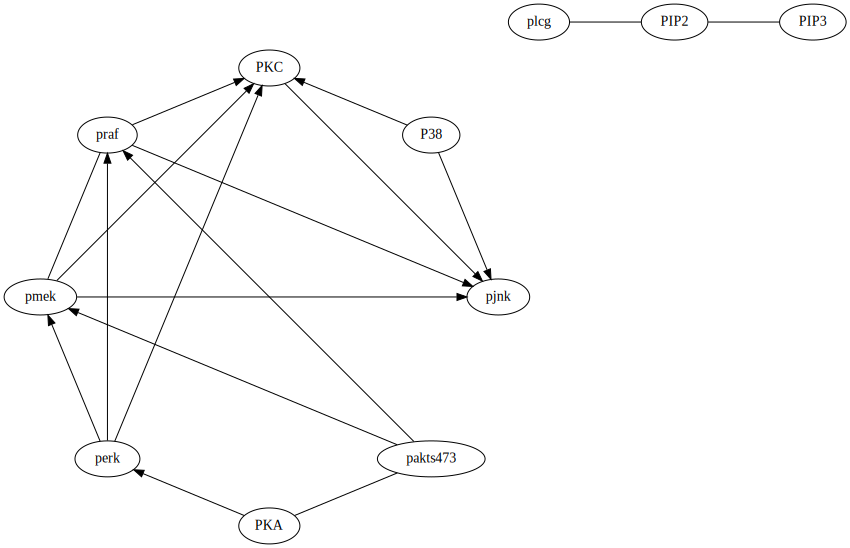

In [30]:
data_exp1_6_drop = data_exp1_6.drop(columns='experiment')
tester1_6 = IndependenceTester(data_exp1_6_drop, ParCorr(), alpha=0.1)

G = PC_algorithm(11, tester1_6)
graph_to_graphviz(G, list(data_exp1_6_drop.columns))

### References
* J. M. Mooij, S. Magliacane, and T. Claassen, "Joint Causal Inference from Multiple Contexts," [arXiv:1611.10351v4](https://arxiv.org/abs/1611.10351), 2019.
* J. Runge, "Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information" In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics, http://proceedings.mlr.press/v84/runge18a.html, 2018.
* K. Sachs, O. Perez, D. Pe’er, D. A. Lauffenburger, and G. P. Nolan, "Causal protein-signaling networks derived from multiparameter single-cell data," Science, vol. 308, no. 5721, pp. 523–529, 2005.